# Setup

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv

import scanpy as sc
import scanpy.external as sce

from igraph import *
import ipywidgets
from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
import anndata
from anndata import read_h5ad
import arrow
import bbknn
import leidenalg

sc.settings.verbosity = 3
sc.logging.print_versions()
np.random.seed(685)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.set_figure_params(dpi=50)

scanpy==1.4.5.dev147+g724da7d anndata==0.6.22.post1 numpy==1.17.4 scipy==1.3.3 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [7]:
def plot_colortable(colors, title, sort_colors=True, emptycols=0):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    # Sort colors by hue, saturation, value and name.
    by_hsv = [(v, k) for k, v in colors.items()]
    
    if sort_colors is True:
        by_hsv = sorted(by_hsv)
    names = [name for hsv, name in by_hsv]

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left", pad=10)

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        swatch_end_x = cell_width * col + swatch_width
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.hlines(y, swatch_start_x, swatch_end_x,
                  color=colors[name], linewidth=18)

    return fig



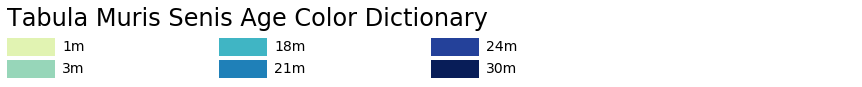

In [8]:
def age_color_dict():
    ages = ['1m','3m','18m','21m','24m','30m']
    
    import matplotlib.colors as pltcolors
    
    cmap = plt.cm.get_cmap("YlGnBu")
        
    age_color_dict = {}
    j=1/len(ages)
    for a in ages:
        age_color_dict[a] = pltcolors.to_hex(cmap(j))
        j+=1/len(ages)
        

    
    return age_color_dict

age_color_dict = age_color_dict()

plot_colortable(age_color_dict, "Tabula Muris Senis Age Color Dictionary", sort_colors=False, emptycols=1)

# Mutation analysis

## prepare GATK data

### FACS adata

In [ ]:
adata = read_h5ad('/data/maca/maca-data-release-v4/tabula-muris-senis-facs-official-raw-obj.h5ad')
adata
# AnnData object with n_obs × n_vars = 164311 × 23341

In [ ]:
gencode_vars = pd.read_csv('/data/maca/maca-data-release-v4/170907_A00111_0051_BH2HWLDMXX.csv',low_memory=False)
gencode_vars = gencode_vars['gene']
gencode_vars = gencode_vars[:-5]
gencode_vars.tail()

### read 3m GATK data

In [ ]:
adata_gatk_3m = read_h5ad('../gatk-analysis/adata_gatk_3m.h5ad')
display(adata_gatk_3m)

ercc_gatk_3m = read_h5ad('../gatk-analysis/ercc_gatk_3m.h5ad')
ercc_gatk_3m

#### convert 3m pickle to h5ad

In [ ]:
from scipy.sparse import csr_matrix
from collections import Counter

adata_gatk_3mx = np.zeros([len(adata.obs[adata.obs['age']=='3m']), len(list(gencode_vars))])
adata_gatk_3m = anndata.AnnData(obs = adata.obs[adata.obs['age']=='3m'],
                               X = adata_gatk_3mx)
adata_gatk_3m.var_names = list(gencode_vars)
del adata_gatk_3mx
adata_gatk_3m.obs['cell_matching'] = [c.split('.mus')[0] for c in adata_gatk_3m.obs['cell'] if c == str(c)]
adata_gatk_3m.obs['cell_matching'] = ['_'.join(c.split('.')[:2]) for c in adata_gatk_3m.obs['cell_matching']]
adata_gatk_3m.obs['cell_matching'] = ['_'.join(c.split('_')[:2]) for c in adata_gatk_3m.obs['cell_matching']]

unpickled_df3 = pd.read_pickle('../gatk-analysis/3_month_snps.pickle')

cellnames = list(unpickled_df3.keys())
cellnames = [c.split('.')[0] for c in cellnames]
cellnames = ['_'.join(c.split('-')[:2]) for c in cellnames]
cellnames = ['_'.join(c.split('_')[:2]) for c in cellnames]
cellnamesdict = dict(zip(cellnames,list(unpickled_df3.keys())))

i = 0
for k in adata_gatk_3m.obs['cell_matching']:
    try:
        t = [g.split('__')[1] for g in unpickled_df3[cellnamesdict[k]]]
        c=Counter(t)
        df = pd.DataFrame.from_dict(c, orient='index')
        a = df.index[df.index.isin(adata_gatk_3m.var_names)]
        adata_gatk_3m[adata_gatk_3m.obs[adata_gatk_3m.obs['cell_matching']==k].index[0],a].X = df.loc[a][0].values
    except:
        i+=1
        adata_gatk_3m[adata_gatk_3m.obs[adata_gatk_3m.obs['cell_matching']==k].index[0]].X = 0
        

adata_gatk_3m.X = csr_matrix(adata_gatk_3m.X)
adata_gatk_3m.write('../gatk-analysis/adata_with_ercc_gatk_3m.h5ad')

adata_gatk_3m

In [ ]:
ercc_gatk_3m = adata_gatk_3m[:,adata_gatk_3m.var_names[adata_gatk_3m.var_names.str.startswith('ER')]].copy()
adata_gatk_3m = adata_gatk_3m[:,adata_gatk_3m.var_names[~adata_gatk_3m.var_names.str.startswith('ER')]]

ercc_gatk_3m, adata_gatk_3m

In [ ]:
adata_gatk_3m.obs['nmutations'] = adata_gatk_3m.X.todense().sum(axis=1)
ercc_gatk_3m.obs['nmutations'] = ercc_gatk_3m.X.todense().sum(axis=1)

In [ ]:
adata_gatk_3m, ercc_gatk_3m

In [ ]:
adata_gatk_3m.write('../gatk-analysis/adata_gatk_3m.h5ad')
ercc_gatk_3m.write('../gatk-analysis/ercc_gatk_3m.h5ad')

### read 18m GATK data

In [ ]:
adata_gatk_18m = read_h5ad('../gatk-analysis/adata_gatk_18m.h5ad')
display(adata_gatk_18m)

ercc_gatk_18m = read_h5ad('../gatk-analysis/ercc_gatk_18m.h5ad')
ercc_gatk_18m

#### convert 18m pickle to h5ad

In [ ]:
from scipy.sparse import csr_matrix
from collections import Counter

adata_gatk_18mx = np.zeros([len(adata.obs[adata.obs['age']=='18m']), len(list(gencode_vars))])
adata_gatk_18m = anndata.AnnData(obs = adata.obs[adata.obs['age']=='18m'],
                               X = adata_gatk_18mx)
adata_gatk_18m.var_names = list(gencode_vars)
adata_gatk_18m = adata_gatk_18m[adata_gatk_18m.obs['tissue']!='Mammary_Gland'].copy()
del adata_gatk_18mx

adata_gatk_18m.obs['cell_matching'] = adata_gatk_18m.obs_names
adata_gatk_18m.obs['cell_matching'] = [a.split('.')[0] for a in adata_gatk_18m.obs['cell_matching']]
adata_gatk_18m.obs['cell_matching'] = adata_gatk_18m.obs['cell_matching']+ '.gencode.vM19.ERCC.Aligned.out.sorted.bam.read_groups.bam'

unpickled_df18 = pd.read_pickle('../gatk-analysis/snps_for_18_months.pickle')

i = 0
for k in adata_gatk_18m.obs['cell_matching']:
    try:
        t = [g.split('__')[1] for g in unpickled_df18[k]]
        c=Counter(t)
        df = pd.DataFrame.from_dict(c, orient='index')
        a = df.index[df.index.isin(adata_gatk_18m.var_names)]
        adata_gatk_18m[adata_gatk_18m.obs[adata_gatk_18m.obs['cell_matching']==k].index[0],a].X = df.loc[a][0].values
    except:
        i+=1
        adata_gatk_18m[adata_gatk_18m.obs[adata_gatk_18m.obs['cell_matching']==k].index[0]].X = 0
        

adata_gatk_18m.X = csr_matrix(adata_gatk_18m.X)
adata_gatk_18m.write('../gatk-analysis/adata_with_ercc_gatk_18m.h5ad')
adata_gatk_18m


In [ ]:
ercc_gatk_18m = adata_gatk_18m[:,adata_gatk_18m.var_names[adata_gatk_18m.var_names.str.startswith('ER')]].copy()
adata_gatk_18m = adata_gatk_18m[:,adata_gatk_18m.var_names[~adata_gatk_18m.var_names.str.startswith('ER')]]

ercc_gatk_18m, adata_gatk_18m

In [ ]:
adata_gatk_18m.obs['nmutations'] = adata_gatk_18m.X.todense().sum(axis=1)
ercc_gatk_18m.obs['nmutations'] = ercc_gatk_18m.X.todense().sum(axis=1)

In [ ]:
adata_gatk_18m, ercc_gatk_18m

In [ ]:
adata_gatk_18m.write('../gatk-analysis/adata_gatk_18m.h5ad')
ercc_gatk_18m.write('../gatk-analysis/ercc_gatk_18m.h5ad')

### read 18 & 21m GATK Mammary Gland data

In [ ]:
adata_gatk_21m = read_h5ad('../gatk-analysis/adata_gatk_21m.h5ad')
display(adata_gatk_21m)

ercc_gatk_21m = read_h5ad('../gatk-analysis/ercc_gatk_21m.h5ad')
ercc_gatk_21m

#### convert 21m pickle to h5ad

In [ ]:
from scipy.sparse import csr_matrix
from collections import Counter

aux = adata[adata.obs['age'].isin(['18m','21m'])]
aux = aux[aux.obs['tissue']=='Mammary_Gland']

adata_gatk_21mx = np.zeros([len(aux), len(list(gencode_vars))])
adata_gatk_21m = anndata.AnnData(obs = aux.obs,
                               X = adata_gatk_21mx)

adata_gatk_21m.var_names = list(gencode_vars)
del adata_gatk_21mx
adata_gatk_21m.obs['cell_matching'] = [c.split('.mus')[0] for c in adata_gatk_21m.obs['cell'] if c == str(c)]
adata_gatk_21m.obs['cell_matching'] = ['_'.join(c.split('.')[:2]) for c in adata_gatk_21m.obs['cell_matching']]
adata_gatk_21m.obs['cell_matching'] = ['_'.join(c.split('_')[:2]) for c in adata_gatk_21m.obs['cell_matching']]

unpickled_df21 = pd.read_pickle('../gatk-analysis/21_month_snps.pickle')

cellnames = list(unpickled_df21.keys())
cellnames = [c.split('.')[0] for c in cellnames]
cellnames = ['_'.join(c.split('-')[:2]) for c in cellnames]
cellnames = ['_'.join(c.split('_')[:2]) for c in cellnames]
cellnamesdict = dict(zip(cellnames,list(unpickled_df21.keys())))

i = 0
for k in adata_gatk_21m.obs['cell_matching']:
    try:
        t = [g.split('__')[1] for g in unpickled_df21[cellnamesdict[k]]]
        c=Counter(t)
        df = pd.DataFrame.from_dict(c, orient='index')
        a = df.index[df.index.isin(adata_gatk_21m.var_names)]
        adata_gatk_21m[adata_gatk_21m.obs[adata_gatk_21m.obs['cell_matching']==k].index[0],a].X = df.loc[a][0].values
    except:
        i+=1
        adata_gatk_21m[adata_gatk_21m.obs[adata_gatk_21m.obs['cell_matching']==k].index[0]].X = 0
        

adata_gatk_21m.X = csr_matrix(adata_gatk_21m.X)
adata_gatk_21m.write('../gatk-analysis/adata_with_ercc_gatk_21m.h5ad')

adata_gatk_21m

In [ ]:
i

In [ ]:
ercc_gatk_21m = adata_gatk_21m[:,adata_gatk_21m.var_names[adata_gatk_21m.var_names.str.startswith('ER')]].copy()
adata_gatk_21m = adata_gatk_21m[:,adata_gatk_21m.var_names[~adata_gatk_21m.var_names.str.startswith('ER')]]

ercc_gatk_21m, adata_gatk_21m

In [ ]:
adata_gatk_21m.obs['nmutations'] = adata_gatk_21m.X.todense().sum(axis=1)
ercc_gatk_21m.obs['nmutations'] = ercc_gatk_21m.X.todense().sum(axis=1)

In [ ]:
adata_gatk_21m, ercc_gatk_21m

In [ ]:
adata_gatk_21m.write('../gatk-analysis/adata_gatk_21m.h5ad')
ercc_gatk_21m.write('../gatk-analysis/ercc_gatk_21m.h5ad')

### read 24m GATK data

In [ ]:
adata_gatk_24m = read_h5ad('../gatk-analysis/adata_gatk_24m.h5ad')
display(adata_gatk_24m)

ercc_gatk_24m = read_h5ad('../gatk-analysis/ercc_gatk_24m.h5ad')
ercc_gatk_24m

#### convert 24m pickle to h5ad

In [ ]:
from scipy.sparse import csr_matrix
from collections import Counter

adata_gatk_24mx = np.zeros([len(adata.obs[adata.obs['age']=='24m']), len(list(gencode_vars))])
adata_gatk_24m = anndata.AnnData(obs = adata.obs[adata.obs['age']=='24m'],
                               X = adata_gatk_24mx)
adata_gatk_24m.var_names = list(gencode_vars)
del adata_gatk_24mx
adata_gatk_24m.obs['cell_matching'] = [c.split('.mus')[0] for c in adata_gatk_24m.obs['cell'] if c == str(c)]
adata_gatk_24m.obs['cell_matching'] = ['_'.join(c.split('.')[:2]) for c in adata_gatk_24m.obs['cell_matching']]
adata_gatk_24m.obs['cell_matching'] = ['_'.join(c.split('_')[:2]) for c in adata_gatk_24m.obs['cell_matching']]

unpickled_df24 = pd.read_pickle('../gatk-analysis/24_month_snps.pickle')

cellnames = list(unpickled_df24.keys())
cellnames = [c.split('.')[0] for c in cellnames]
cellnames = ['_'.join(c.split('-')[:2]) for c in cellnames]
cellnames = ['_'.join(c.split('_')[:2]) for c in cellnames]
cellnamesdict = dict(zip(cellnames,list(unpickled_df24.keys())))

i = 0
for k in adata_gatk_24m.obs['cell_matching']:
    try:
        t = [g.split('__')[1] for g in unpickled_df24[cellnamesdict[k]]]
        c=Counter(t)
        df = pd.DataFrame.from_dict(c, orient='index')
        a = df.index[df.index.isin(adata_gatk_24m.var_names)]
        adata_gatk_24m[adata_gatk_24m.obs[adata_gatk_24m.obs['cell_matching']==k].index[0],a].X = df.loc[a][0].values
    except:
        i+=1
        adata_gatk_24m[adata_gatk_24m.obs[adata_gatk_24m.obs['cell_matching']==k].index[0]].X = 0
        

adata_gatk_24m.X = csr_matrix(adata_gatk_24m.X)
adata_gatk_24m.write('../gatk-analysis/adata_with_ercc_gatk_24m.h5ad')

adata_gatk_24m

In [ ]:
ercc_gatk_24m = adata_gatk_24m[:,adata_gatk_24m.var_names[adata_gatk_24m.var_names.str.startswith('ER')]].copy()
adata_gatk_24m = adata_gatk_24m[:,adata_gatk_24m.var_names[~adata_gatk_24m.var_names.str.startswith('ER')]]

ercc_gatk_24m, adata_gatk_24m

In [ ]:
adata_gatk_24m.obs['nmutations'] = adata_gatk_24m.X.todense().sum(axis=1)
ercc_gatk_24m.obs['nmutations'] = ercc_gatk_24m.X.todense().sum(axis=1)

In [ ]:
adata_gatk_24m, ercc_gatk_24m

In [ ]:
adata_gatk_24m.write('../gatk-analysis/adata_gatk_24m.h5ad')
ercc_gatk_24m.write('../gatk-analysis/ercc_gatk_24m.h5ad')

### merge GATK objects

In [ ]:
adata_ercc_gatk_3m = read_h5ad('../gatk-analysis/adata_with_ercc_gatk_3m.h5ad')
adata_ercc_gatk_18m = read_h5ad('../gatk-analysis/adata_with_ercc_gatk_18m.h5ad')
adata_ercc_gatk_21m = read_h5ad('../gatk-analysis/adata_with_ercc_gatk_21m.h5ad')
adata_ercc_gatk_24m = read_h5ad('../gatk-analysis/adata_with_ercc_gatk_24m.h5ad')

adata_ercc_gatk = adata_ercc_gatk_3m.concatenate(adata_ercc_gatk_18m)
adata_ercc_gatk = adata_ercc_gatk.concatenate(adata_ercc_gatk_21m)
adata_ercc_gatk = adata_ercc_gatk.concatenate(adata_ercc_gatk_24m)

adata_ercc_gatk.write('../gatk-analysis/adata_with_ercc_gatk_all_data_with_metadata.h5ad')

adata_ercc_gatk

In [ ]:
adata_gatk = adata_gatk_3m.concatenate(adata_gatk_18m)
adata_gatk = adata_gatk.concatenate(adata_gatk_21m)
adata_gatk = adata_gatk.concatenate(adata_gatk_24m)
adata_gatk

In [ ]:
ercc_gatk = ercc_gatk_3m.concatenate(ercc_gatk_18m)
ercc_gatk = ercc_gatk.concatenate(ercc_gatk_21m)
ercc_gatk = ercc_gatk.concatenate(ercc_gatk_24m)
ercc_gatk

In [ ]:
adata_gatk.write('../gatk-analysis/adata_gatk_all_data_with_metadata.h5ad')
ercc_gatk.write('../gatk-analysis/ercc_gatk_all_data_with_metadata.h5ad')

In [ ]:
adata_gatk.obs.columns

In [ ]:
adata_gatk.obs.groupby(['tissue'])['age'].agg({'len':len})

## prepare raw gencode data

In [ ]:
adata_gatk = read_h5ad('../gatk-analysis/adata_with_ercc_gatk_all_data_with_metadata.h5ad')
adata_gatk

In [ ]:
adata_counts = read_h5ad('../gatk-analysis/maca-gencode-all-ages.h5ad')
display(adata_counts)

from scipy.sparse import csr_matrix
m21 = anndata.read_csv('../gatk-analysis/181207_A00111_0239_BH3WNVDRXX_gencode.csv')
m21 = m21.transpose()
m21.X = csr_matrix(m21.X)
display(m21)

adata_counts = adata_counts.concatenate(m21)
adata_counts = adata_counts[:,adata_counts.var_names[:-5]]
adata_counts

In [ ]:
adata_counts.obs['newcellnames'] = adata_counts.obs.index.values
adata_counts.obs['newcellnames'] = adata_counts.obs['newcellnames'].str.replace('-','_')
adata_counts.obs['newcellnames'] = adata_counts.obs['newcellnames'].str.replace('.','_')
adata_counts.obs['newcellnames'] = ['_'.join(nc.split('_',2)[:2]) for nc in adata_counts.obs['newcellnames']]

aux = adata_counts.obs[~adata_counts.obs['newcellnames'].isin(
    adata_gatk.obs['cell_matching'].values)]

aux['newcellnames'] = [a.split('.')[0] for a in list(aux.index)]
aux['newcellnames'] = aux['newcellnames'] + '.gencode.vM19.ERCC.Aligned.out.sorted.bam.read_groups.bam'

aux = aux[aux['newcellnames'].isin(adata_gatk.obs['cell_matching'].values)]

adata_counts.obs.loc[aux.index,'newcellnames'] = aux.loc[aux.index,'newcellnames']
adata_counts = adata_counts[~adata_counts.obs.duplicated()]

adata_counts

In [ ]:
metadata = adata_gatk.obs
metadata['index'] = metadata.index.values
metadata = metadata.drop('batch',axis=1)
metadata = metadata[metadata['cell_matching'].isin(adata_counts.obs['newcellnames'].values)]
metadata.shape

In [ ]:
adata_counts = adata_counts[adata_counts.obs['newcellnames'].isin(metadata['cell_matching'].values)]
adata_counts.obs['gencode_index'] = adata_counts.obs.index.values
adata_counts.obs = adata_counts.obs.drop('batch',axis=1)
adata_counts

In [ ]:
adata_counts.obs = adata_counts.obs.merge(
    metadata, left_on ='newcellnames', right_on='cell_matching')
adata_counts.obs = adata_counts.obs.set_index('index')
adata_counts.obs.head()

In [ ]:
adata_counts.obs.groupby(['age'])['age'].agg({'len':len})

In [ ]:
adata_counts.write('../gatk-analysis/adata_with_ercc_genecode_counts_for_gatk_with_metadata.h5ad')

In [ ]:
ercc_counts = adata_counts[:,adata_counts.var_names.str.startswith('ER')]
ercc_counts.write('../gatk-analysis/ercc_genecode_counts_for_gatk_with_metadata.h5ad')


In [ ]:
adata_counts = adata_counts[:,~adata_counts.var_names.str.startswith('ER')]
adata_counts.write('../gatk-analysis/adata_genecode_counts_for_gatk_with_metadata.h5ad')


In [ ]:
ercc_counts, adata_counts

## read GATK+ERCC data

In [6]:
adata_ercc_gatk = read_h5ad('../gatk-analysis/adata_with_ercc_gatk_all_data_with_metadata.h5ad')
adata_ercc_counts = read_h5ad('../gatk-analysis/adata_with_ercc_genecode_counts_for_gatk_with_metadata.h5ad')

adata_ercc_gatk,adata_ercc_counts

(AnnData object with n_obs × n_vars = 164311 × 54444 
     obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_matching', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue',
 AnnData object with n_obs × n_vars = 161216 × 54444 
     obs: 'newcellnames', 'gencode_index', 'FACS.selection', 'age', 'cell', 'cell_matching', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue')

In [7]:
adata_ercc_counts = adata_ercc_counts[adata_ercc_counts.obs['cell_ontology_class']!='nan']
display(adata_ercc_counts)

View of AnnData object with n_obs × n_vars = 109450 × 54444 
    obs: 'newcellnames', 'gencode_index', 'FACS.selection', 'age', 'cell', 'cell_matching', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue'

In [8]:
adata_ercc_gatk = adata_ercc_gatk[adata_ercc_gatk.obs.index.isin(adata_ercc_counts.obs.index)]
display(adata_ercc_gatk)

View of AnnData object with n_obs × n_vars = 109450 × 54444 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_matching', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue'

In [10]:
sc.pp.filter_genes(adata_ercc_gatk, min_cells=1)
adata_ercc_gatk

filtered out 6869 genes that are detected in less than 1 cells


Trying to set attribute `.var` of view, copying.


AnnData object with n_obs × n_vars = 109450 × 47575 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_matching', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue'
    var: 'n_cells'

In [11]:
sc.pp.filter_cells(adata_ercc_counts,min_genes=0)

Trying to set attribute `.obs` of view, copying.


In [12]:
adata_ercc_counts = adata_ercc_counts[:,adata_ercc_counts.var_names.isin(adata_ercc_gatk.var_names)]
sc.pp.filter_cells(adata_ercc_counts,min_genes=0)

adata_ercc_counts

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 109450 × 47575 
    obs: 'newcellnames', 'gencode_index', 'FACS.selection', 'age', 'cell', 'cell_matching', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes'

In [13]:
import gc
gc.collect()

15978

In [14]:
sc.pp.filter_genes(adata_ercc_counts, min_cells=3)

filtered out 1295 genes that are detected in less than 3 cells


In [15]:
adata_ercc_counts, adata_ercc_gatk

(AnnData object with n_obs × n_vars = 109450 × 46280 
     obs: 'newcellnames', 'gencode_index', 'FACS.selection', 'age', 'cell', 'cell_matching', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes'
     var: 'n_cells', AnnData object with n_obs × n_vars = 109450 × 47575 
     obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_matching', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue'
     var: 'n_cells')

In [16]:
adata_ercc_gatk = adata_ercc_gatk[:,adata_ercc_gatk.var_names.isin(adata_ercc_counts.var_names)]
sc.pp.filter_cells(adata_ercc_gatk,min_genes=0)

adata_ercc_gatk

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 109450 × 46280 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_matching', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes'
    var: 'n_cells'

In [17]:
adata_ercc_gatk.obs.groupby(['age'])['tissue'].count()

age
3m     43638
18m    33770
21m      727
24m    31315
Name: tissue, dtype: int64

In [18]:
countsgenemutations = pd.DataFrame(index = adata_ercc_gatk.var_names,columns = ['3m','18m','21m','24m'])
aux = adata_ercc_gatk[adata_ercc_gatk.obs['age']=='3m']
countsgenemutations['3m'] = (np.sum(aux.X>0,axis=0)/aux.shape[0]).transpose()
aux = adata_ercc_gatk[adata_ercc_gatk.obs['age']=='18m']
countsgenemutations['18m'] = (np.sum(aux.X>0,axis=0)/aux.shape[0]).transpose()
aux = adata_ercc_gatk[adata_ercc_gatk.obs['age']=='21m']
countsgenemutations['21m'] = (np.sum(aux.X>0,axis=0)/aux.shape[0]).transpose()
aux = adata_ercc_gatk[adata_ercc_gatk.obs['age']=='24m']
countsgenemutations['24m'] = (np.sum(aux.X>0,axis=0)/aux.shape[0]).transpose()
del aux
countsgenemutations['avg'] = countsgenemutations.sum(axis=1)/4
countsgenemutations.sort_values(by='avg',ascending=False)

,3m,18m,21m,24m,avg
CT010467.1,0.998006,0.999200,1.00000,0.999745,0.999238
Gm42418,0.988175,0.998519,1.00000,0.999649,0.996586
Gm26561,0.824809,0.914125,0.98762,0.911959,0.909628
Gm10076,0.811563,0.922298,1.00000,0.876257,0.902530
Actb,0.755305,0.898549,0.97249,0.922401,0.887186
...,...,...,...,...,...
Mir6374,0.000023,0.000000,0.00000,0.000000,0.000006
Mir6367,0.000023,0.000000,0.00000,0.000000,0.000006
Mir6358,0.000023,0.000000,0.00000,0.000000,0.000006
Gm48731,0.000023,0.000000,0.00000,0.000000,0.000006


In [19]:
housekeeping_mutations = countsgenemutations.loc[countsgenemutations['avg']>.6].index
housekeeping_mutations

Index(['AC154187.2', 'Abr', 'Actb', 'Actg1', 'Akr1a1', 'Aldoa', 'Arf1',
       'Arhgdia', 'Arpc2', 'Atp5b',
       ...
       'Tmbim6', 'Tpm3', 'Ubb', 'Vmp1', 'Ybx1', 'Ywhae', 'Ywhaz', 'Zbtb20',
       'Zc3h7a', 'a'],
      dtype='object', length=111)

In [21]:
sc.pp.filter_cells(adata_ercc_counts,min_genes=1)
sc.pp.filter_cells(adata_ercc_gatk,min_genes=0)

adata_ercc_gatk,adata_ercc_counts

(AnnData object with n_obs × n_vars = 109450 × 46280 
     obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_matching', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes'
     var: 'n_cells', AnnData object with n_obs × n_vars = 109450 × 46280 
     obs: 'newcellnames', 'gencode_index', 'FACS.selection', 'age', 'cell', 'cell_matching', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes'
     var: 'n_cells')

In [22]:
genestoremove = list(set(housekeeping_mutations))
len(genestoremove)

111

In [23]:
adata_ercc_gatk = adata_ercc_gatk[:,~adata_ercc_gatk.var_names.isin(genestoremove)]
adata_ercc_counts = adata_ercc_counts[:,~adata_ercc_counts.var_names.isin(genestoremove)]

sc.pp.filter_cells(adata_ercc_counts,min_genes=0)
sc.pp.filter_cells(adata_ercc_gatk,min_genes=0)

adata_ercc_gatk,adata_ercc_counts

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


(AnnData object with n_obs × n_vars = 109450 × 46169 
     obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_matching', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes'
     var: 'n_cells', AnnData object with n_obs × n_vars = 109450 × 46169 
     obs: 'newcellnames', 'gencode_index', 'FACS.selection', 'age', 'cell', 'cell_matching', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes'
     var: 'n_cells')

In [24]:
counts = adata_ercc_counts.X.todense()
counts = pd.DataFrame(counts,index = adata_ercc_counts.obs_names,
                      columns=adata_ercc_counts.var_names)

genes_tissue_dict = {}
for t in list(set(adata_ercc_counts.obs['tissue'])):
    adata_aux = adata_ercc_counts[adata_ercc_counts.obs['tissue']==t]
    if t == 'Mammary_Gland':
        adata_aux3 = adata_aux[adata_aux.obs['age']=='3m']
        counts_aux3 = counts.loc[adata_aux3.obs_names]
        
        counts_aux3.loc['sum'] = counts_aux3.astype(bool).sum(axis=0)
        
        a3 = counts_aux3.loc['sum']>counts_aux3.shape[0]*3/4
        a3 = list(a3[a3==True].index)
        
        adata_aux18 = adata_aux[adata_aux.obs['age']=='18m']
        counts_aux18 = counts.loc[adata_aux18.obs_names]
        
        counts_aux18.loc['sum'] = counts_aux18.astype(bool).sum(axis=0)
        
        a18 = counts_aux18.loc['sum']>counts_aux18.shape[0]*3/4
        a18 = list(a18[a18==True].index)
        
        adata_aux21 = adata_aux[adata_aux.obs['age']=='21m']
        counts_aux21 = counts.loc[adata_aux21.obs_names]
        
        counts_aux21.loc['sum'] = counts_aux21.astype(bool).sum(axis=0)
        
        a21 = counts_aux21.loc['sum']>counts_aux21.shape[0]*3/4
        a21 = list(a21[a21==True].index)
        
        genes_tissue_dict[t] = list(set(a3) & set(a18) & set(a21))
    else:
        adata_aux3 = adata_aux[adata_aux.obs['age']=='3m']
        counts_aux3 = counts.loc[adata_aux3.obs_names]
        
        counts_aux3.loc['sum'] = counts_aux3.astype(bool).sum(axis=0)
        
        a3 = counts_aux3.loc['sum']>counts_aux3.shape[0]*3/4
        a3 = list(a3[a3==True].index)
        
        adata_aux18 = adata_aux[adata_aux.obs['age']=='18m']
        counts_aux18 = counts.loc[adata_aux18.obs_names]
        
        counts_aux18.loc['sum'] = counts_aux18.astype(bool).sum(axis=0)
        
        a18 = counts_aux18.loc['sum']>counts_aux18.shape[0]*3/4
        a18 = list(a18[a18==True].index)
        
        adata_aux24 = adata_aux[adata_aux.obs['age']=='24m']
        counts_aux24 = counts.loc[adata_aux24.obs_names]
        
        counts_aux24.loc['sum'] = counts_aux24.astype(bool).sum(axis=0)
        a24 = counts_aux24.loc['sum']>counts_aux24.shape[0]*3/4
        a24 = list(a24[a24==True].index)
        
        genes_tissue_dict[t] = list(set(a3) & set(a18) & set(a24))

del counts

for t in list(set(adata_ercc_counts.obs['tissue'])):
    print(t,len(genes_tissue_dict[t]))

Bladder 6
Trachea 10
Brain_Myeloid 158
Liver 113
Brain_Non-Myeloid 42
Aorta 108
Large_Intestine 11
Skin 371
Lung 139
BAT 77
Kidney 65
Tongue 540
Marrow 51
GAT 226
Thymus 142
Spleen 15
Limb_Muscle 146
Diaphragm 101
MAT 194
Pancreas 39
Mammary_Gland 711
SCAT 157
Heart 122


In [1]:
genes_tissue_dict

In [ ]:
adata = adata_ercc_gatk[:,adata_ercc_gatk.var_names[~adata_ercc_gatk.var_names.str.startswith('ERCC')]]
ercc = adata_ercc_gatk[:,adata_ercc_gatk.var_names[adata_ercc_gatk.var_names.str.startswith('ERCC')]]

adata_counts = adata_ercc_counts[:,adata_ercc_counts.var_names[~adata_ercc_counts.var_names.str.startswith('ERCC')]]
ercc_counts = adata_ercc_counts[:,adata_ercc_counts.var_names[adata_ercc_counts.var_names.str.startswith('ERCC')]]

adata,ercc,adata_counts,ercc_counts

In [25]:
from statannot import add_stat_annotation
adata = adata_ercc_gatk[:,adata_ercc_gatk.var_names[~adata_ercc_gatk.var_names.str.startswith('ERCC')]]
ercc = adata_ercc_gatk[:,adata_ercc_gatk.var_names[adata_ercc_gatk.var_names.str.startswith('ERCC')]]

adata_counts = adata_ercc_counts[:,adata_ercc_counts.var_names[~adata_ercc_counts.var_names.str.startswith('ERCC')]]
ercc_counts = adata_ercc_counts[:,adata_ercc_counts.var_names[adata_ercc_counts.var_names.str.startswith('ERCC')]]

sc.pp.filter_cells(adata, min_counts=0)
sc.pp.filter_cells(ercc, min_counts=0)
sc.pp.filter_cells(adata_counts, min_counts=0)
sc.pp.filter_cells(ercc_counts, min_counts=0)

adata.obs['avg_counts'] = 0
adata_counts.obs['avg_counts'] = 0
for t in list(set(adata.obs['tissue'])):
    aux = adata[adata.obs['tissue']==t].copy()
    aux = aux[:,aux.var_names[aux.var_names.isin(genes_tissue_dict[t])]]
    adata.obs.loc[aux.obs.index,'avg_mutations'] = np.mean(aux.X,axis=1)
    
    aux_counts = adata_counts[adata_counts.obs['tissue']==t].copy()
    aux_counts = aux[:,aux_counts.var_names[aux_counts.var_names.isin(genes_tissue_dict[t])]]
    adata_counts.obs.loc[aux_counts.obs.index,'avg_counts'] = np.mean(aux_counts.X,axis=1) 
    
ercc.obs['avg_mutations'] = np.mean(ercc.X,axis=1) 
ercc_counts.obs['avg_counts'] = np.mean(ercc_counts.X,axis=1) 


df_mutations = pd.DataFrame(
    columns = ['ercc','adata','tissue','age','cell_ontology_class'],
    index = adata.obs.index)

df_mutations.loc[df_mutations.index,'ercc'] = ercc.obs.loc[df_mutations.index,'avg_mutations']
df_mutations.loc[df_mutations.index,'adata'] = adata.obs.loc[df_mutations.index,'avg_mutations']
df_mutations.loc[df_mutations.index,'ercc_counts'] = np.log(ercc_counts.obs.loc[df_mutations.index,'avg_counts']+1)
df_mutations.loc[df_mutations.index,'adata_counts'] = np.log(adata_counts.obs.loc[df_mutations.index,'avg_counts']+1)
df_mutations.loc[df_mutations.index,'ercc_raw_counts'] = ercc_counts.obs.loc[df_mutations.index,'avg_counts']
df_mutations.loc[df_mutations.index,'adata_raw_counts'] = adata_counts.obs.loc[df_mutations.index,'avg_counts']
df_mutations.loc[df_mutations.index,'tissue'] = adata.obs.loc[df_mutations.index,'tissue']
df_mutations.loc[df_mutations.index,'age'] = adata.obs.loc[df_mutations.index,'age']
df_mutations.loc[df_mutations.index,'agenum'] = [np.float(a.split('m')[0]) for a in adata.obs.loc[df_mutations.index,'age']]
df_mutations.loc[df_mutations.index,'cell_ontology_class'] = adata.obs.loc[df_mutations.index,'cell_ontology_class']


df_mutations['adata'] = df_mutations['adata'].astype(float)
df_mutations['ercc'] = df_mutations['ercc'].astype(float)
df_mutations['adata_counts'] = df_mutations['adata_counts'].astype(float)
df_mutations['ercc_counts'] = df_mutations['ercc_counts'].astype(float)

tissue_list = list(set(df_mutations['tissue']))
tissue_list.sort()
df_mutations


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


,ercc,adata,tissue,age,cell_ontology_class,ercc_counts,adata_counts,ercc_raw_counts,adata_raw_counts,agenum
A1.B000126.3_39_F.1.1-1-1-0-0-0,0.060976,0.818919,Skin,3m,basal cell of epidermis,3.626939,0.598242,36.597557,0.818919,3.0
A1.B000127.3_38_F.1.1-1-1-0-0-0,0.060976,0.179487,SCAT,3m,endothelial cell,4.532206,0.165080,91.963417,0.179487,3.0
A1.B000167.3_56_F.1.1-1-1-0-0-0,0.109756,1.200565,Mammary_Gland,3m,basal cell,2.905834,0.788714,17.280487,1.200565,3.0
A1.B000412.3_56_F.1.1-1-1-0-0-0,0.097561,0.314050,Heart,3m,endothelial cell of coronary artery,4.982353,0.273114,144.817062,0.314050,3.0
A1.B000633.3_56_F.1.1-1-1-0-0-0,0.121951,1.074380,Heart,3m,monocyte,4.114266,0.729662,60.207310,1.074380,3.0
...,...,...,...,...,...,...,...,...,...,...
P9_B002989_S369_L004.mus-8-0-1-1,0.231707,1.520000,Marrow,24m,hematopoietic stem cell,3.495398,0.924259,31.963413,1.520000,24.0
P9_B002992_S369_L003.mus-8-0-1-1,0.060976,1.200000,Marrow,24m,naive B cell,5.237544,0.788457,187.207306,1.200000,24.0
P9_B003231_S369_L004.mus-8-0-1-1,0.365854,1.355372,Heart,24m,T cell,4.503057,0.856699,89.292679,1.355372,24.0
P9_B003233_S369_L003.mus-8-0-1-1,0.268293,0.950413,Heart,24m,endothelial cell of coronary artery,5.170830,0.668041,175.060974,0.950413,24.0


### Violin plots

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

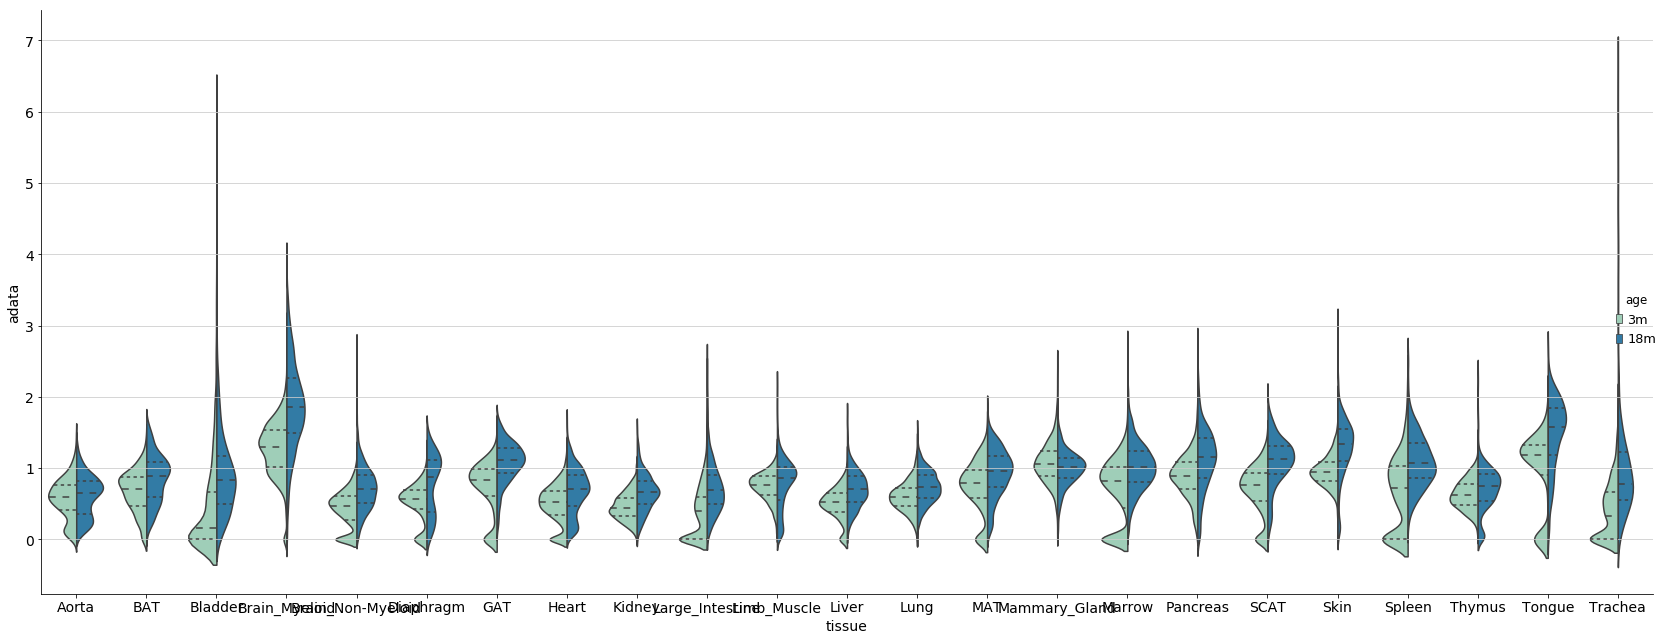

<Figure size 432x288 with 0 Axes>

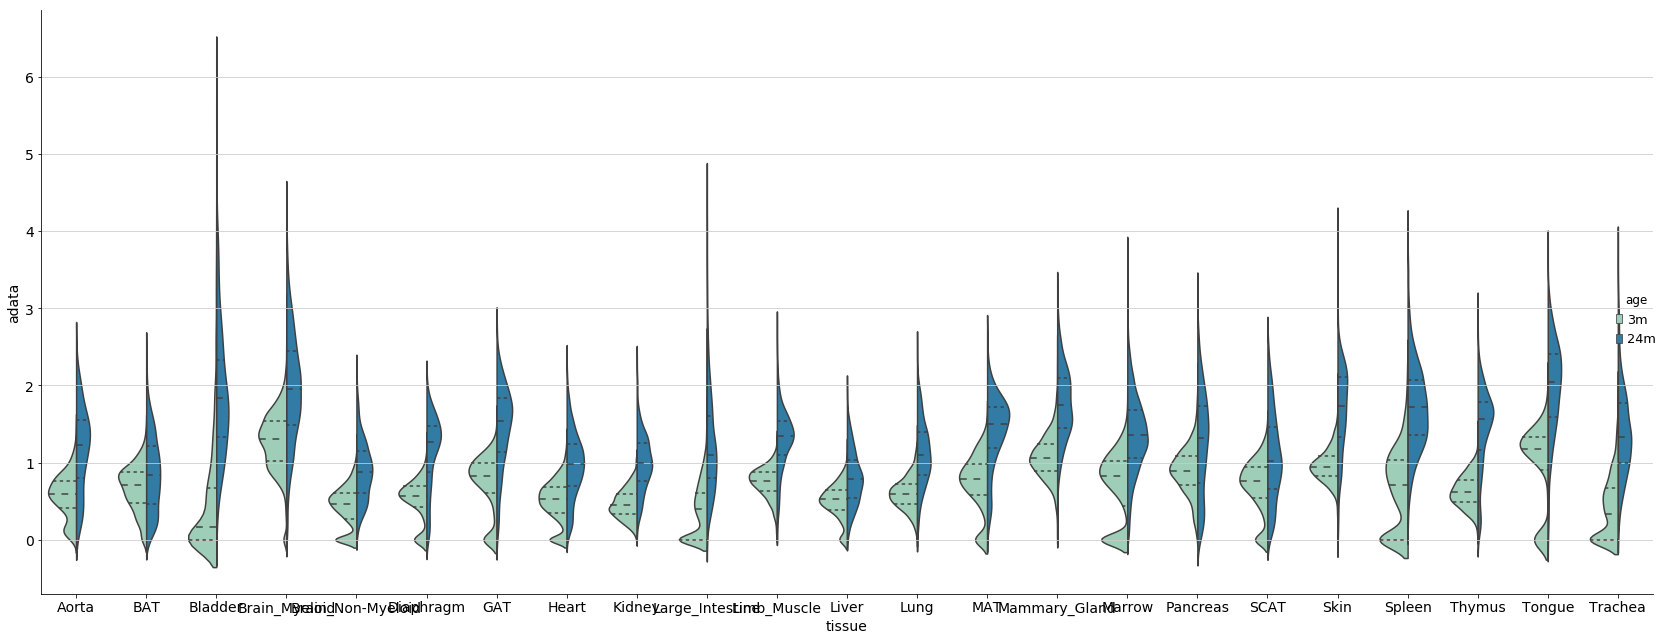

<Figure size 432x288 with 0 Axes>

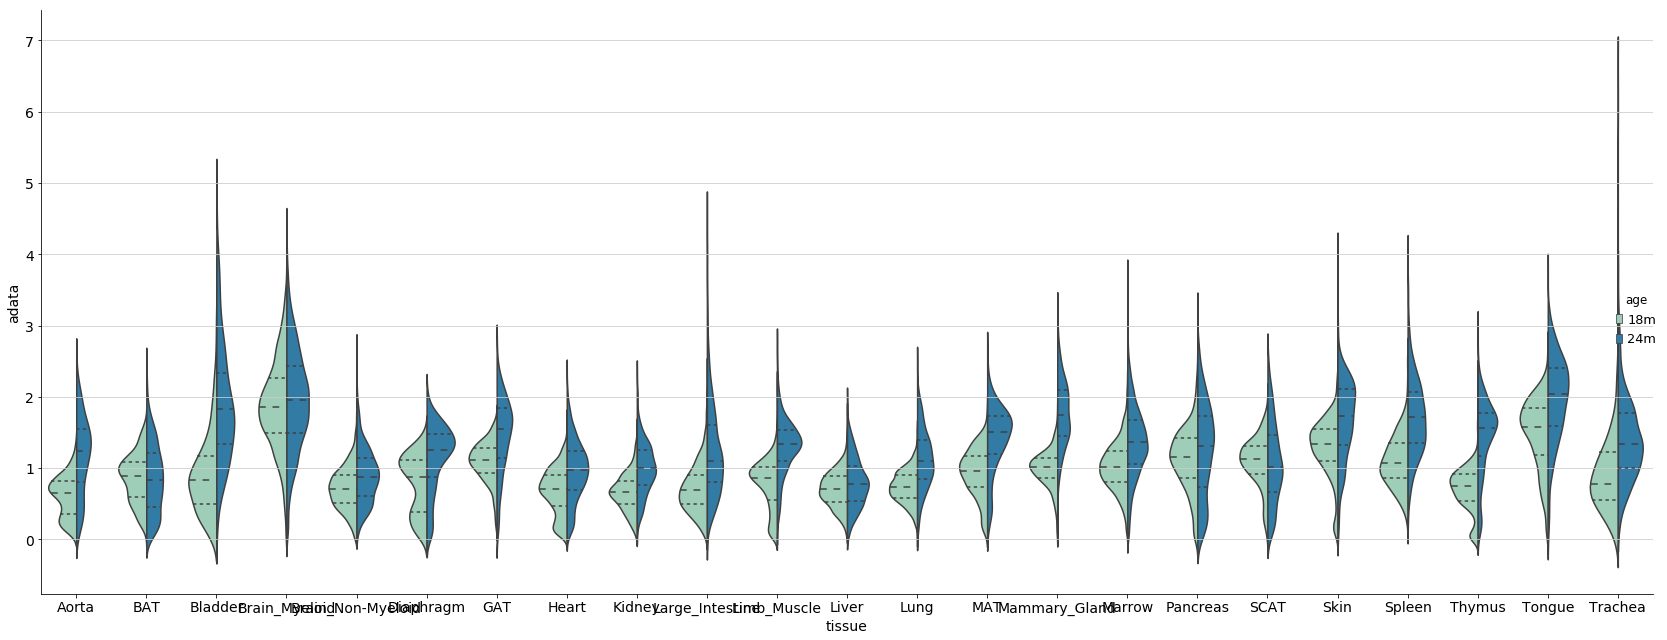

In [30]:
dataofinterest318 = df_mutations[df_mutations['age'].isin(['3m','18m'])]
dataofinterest318['tissue'] = dataofinterest318['tissue'].astype(str)
dataofinterest318['age'] = dataofinterest318['age'].astype(str)
plt.figure()
ax = sns.catplot(x="tissue", y="adata", hue="age",
            kind="violin", split=True, palette="YlGnBu", inner="quartile",
                 order= tissue_list,
                 data=dataofinterest318, height=9, aspect=2.5);
plt.tight_layout()
# plt.savefig('../gatk-analysis/distribution_mutations_3_18.pdf')

dataofinterest324 = df_mutations[df_mutations['age'].isin(['3m','21m','24m'])]
dataofinterest324 = dataofinterest324.replace('21m','24m')
dataofinterest324['tissue'] = dataofinterest324['tissue'].astype(str)
dataofinterest324['age'] = dataofinterest324['age'].astype(str)
plt.figure()
ax = sns.catplot(x="tissue", y="adata", hue="age",
            kind="violin", split=True, palette="YlGnBu", inner="quartile",
                 order= tissue_list,
                 data=dataofinterest324, height=9, aspect=2.5);
plt.tight_layout()
# plt.savefig('../gatk-analysis/distribution_mutations_3_24.pdf')

dataofinterest1824 = df_mutations[df_mutations['age'].isin(['18m','21m','24m'])]
dataofinterest1824 = dataofinterest1824.replace('21m','24m')
dataofinterest1824['tissue'] = dataofinterest1824['tissue'].astype(str)
dataofinterest1824['age'] = dataofinterest1824['age'].astype(str)
plt.figure()
ax = sns.catplot(x="tissue", y="adata", hue="age",
            kind="violin", split=True, palette="YlGnBu", inner="quartile",
                 order= tissue_list,
                 data=dataofinterest1824, height=9, aspect=2.5);
plt.tight_layout()
# plt.savefig('../gatk-analysis/distribution_mutations_18_24.pdf')


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

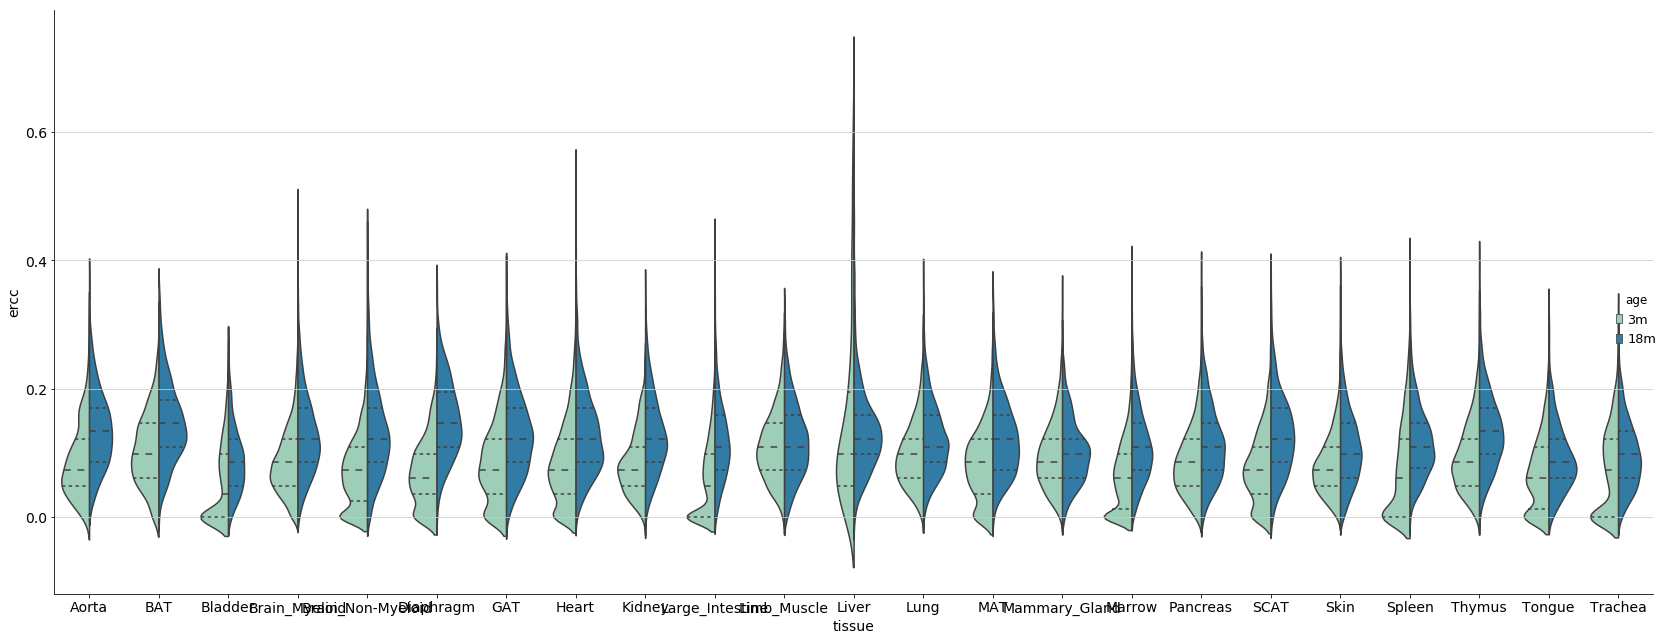

<Figure size 432x288 with 0 Axes>

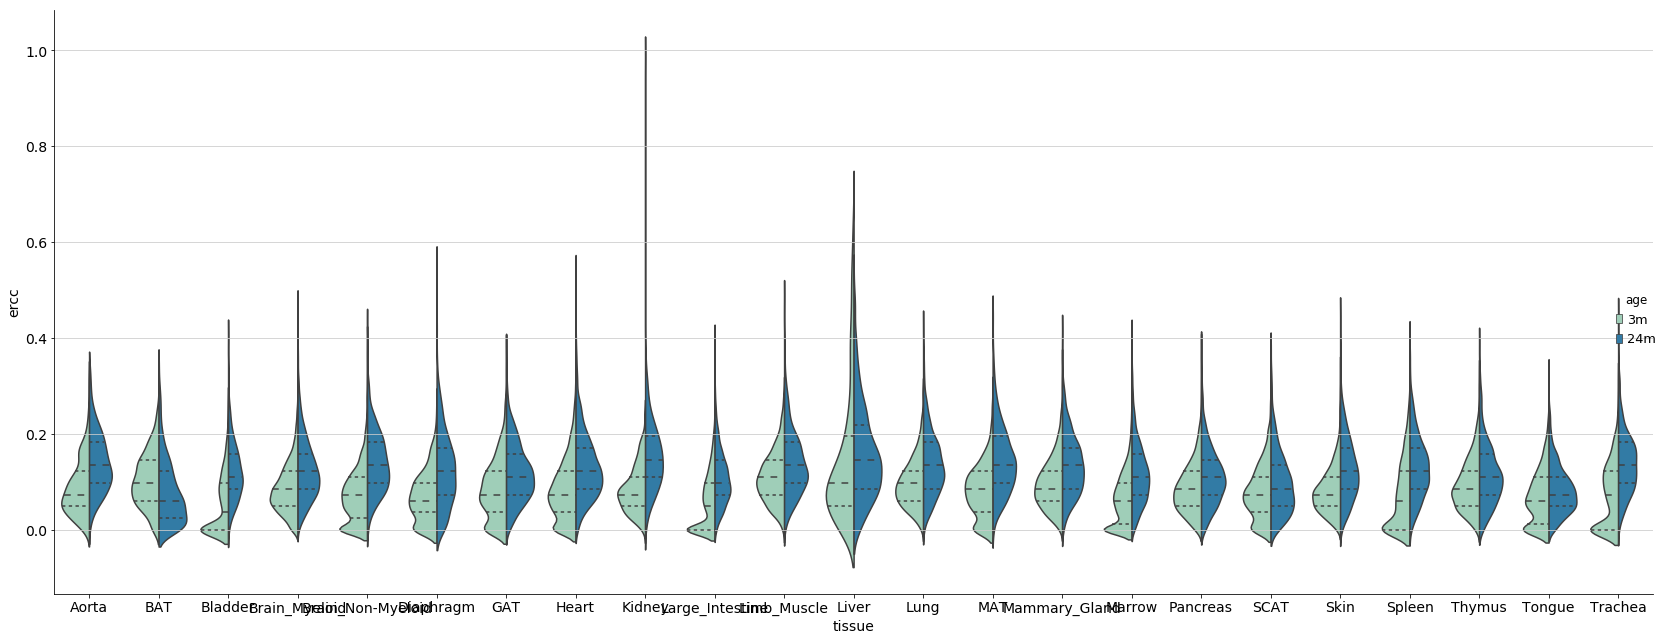

<Figure size 432x288 with 0 Axes>

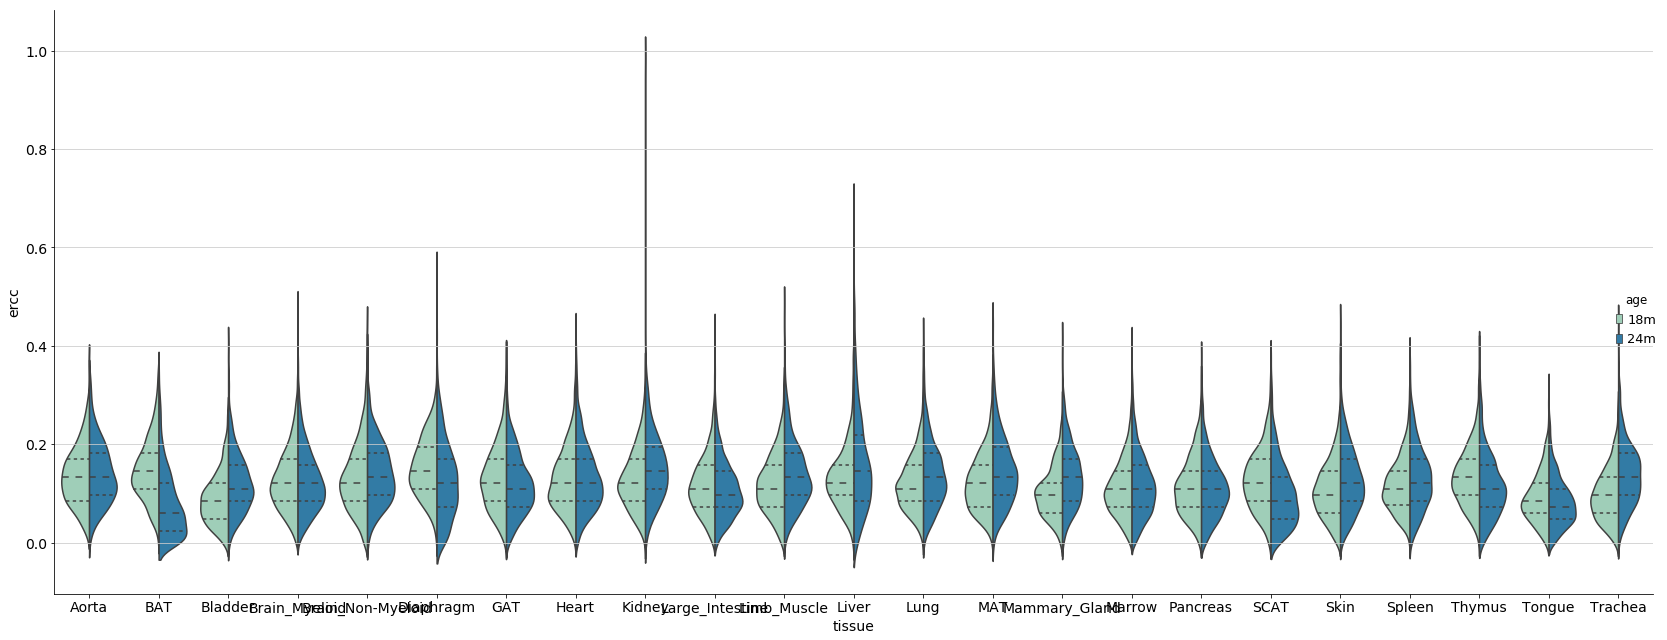

In [31]:
dataofinterest318 = df_mutations[df_mutations['age'].isin(['3m','18m'])]
dataofinterest318['tissue'] = dataofinterest318['tissue'].astype(str)
dataofinterest318['age'] = dataofinterest318['age'].astype(str)
plt.figure()
ax = sns.catplot(x="tissue", y="ercc", hue="age",
            kind="violin", split=True, palette="YlGnBu", inner="quartile",
                 order= tissue_list,
                 data=dataofinterest318, height=9, aspect=2.5);
plt.tight_layout()
# plt.savefig('../gatk-analysis/distribution_mutations_ercc_3_18.pdf')

dataofinterest324 = df_mutations[df_mutations['age'].isin(['3m','21m','24m'])]
dataofinterest324 = dataofinterest324.replace('21m','24m')
dataofinterest324['tissue'] = dataofinterest324['tissue'].astype(str)
dataofinterest324['age'] = dataofinterest324['age'].astype(str)
plt.figure()
ax = sns.catplot(x="tissue", y="ercc", hue="age",
            kind="violin", split=True, palette="YlGnBu", inner="quartile",
                 order= tissue_list,
                 data=dataofinterest324, height=9, aspect=2.5);
plt.tight_layout()
# plt.savefig('../gatk-analysis/distribution_mutations_ercc_3_24.pdf')

dataofinterest1824 = df_mutations[df_mutations['age'].isin(['18m','21m','24m'])]
dataofinterest1824 = dataofinterest1824.replace('21m','24m')
dataofinterest1824['tissue'] = dataofinterest1824['tissue'].astype(str)
dataofinterest1824['age'] = dataofinterest1824['age'].astype(str)
plt.figure()
ax = sns.catplot(x="tissue", y="ercc", hue="age",
            kind="violin", split=True, palette="YlGnBu", inner="quartile",
                 order= tissue_list,
                 data=dataofinterest1824, height=9, aspect=2.5);
plt.tight_layout()
# plt.savefig('../gatk-analysis/distribution_mutations_ercc_18_24.pdf')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

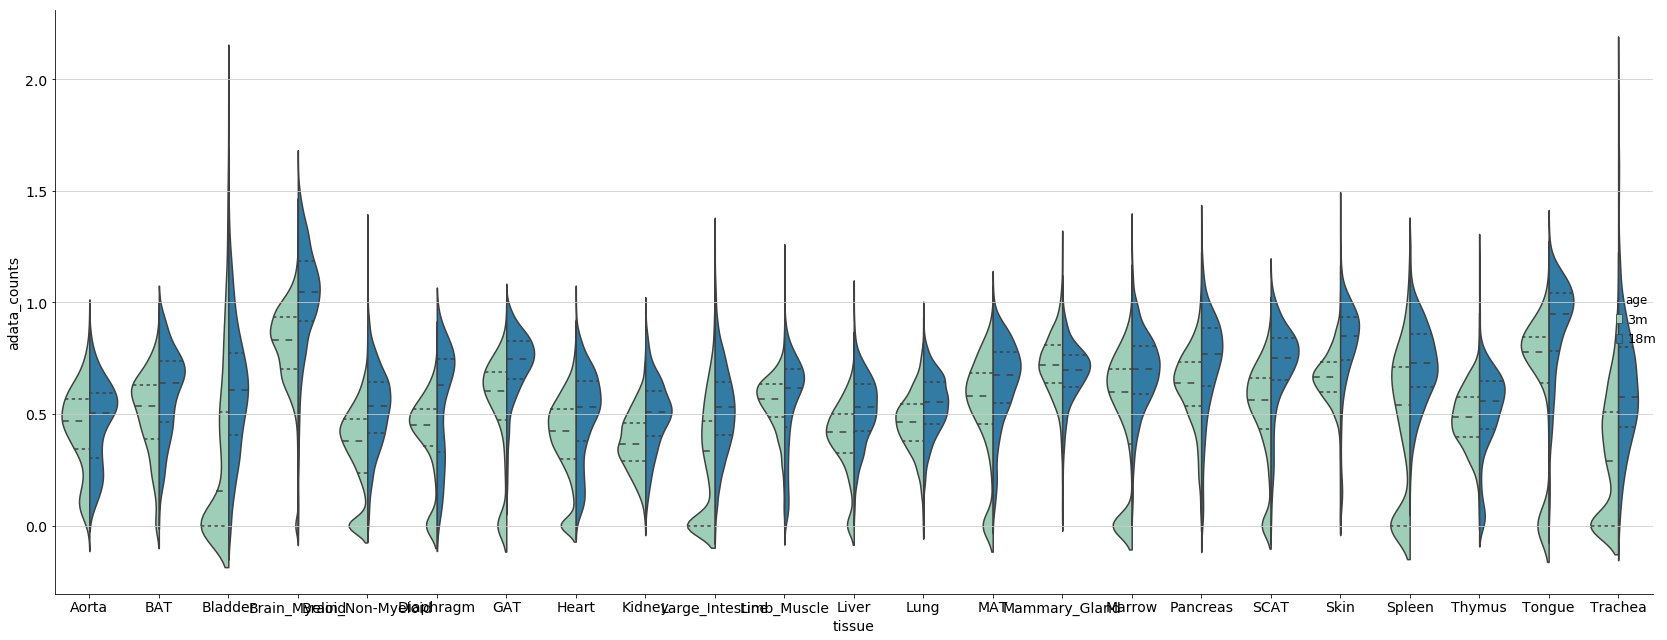

<Figure size 432x288 with 0 Axes>

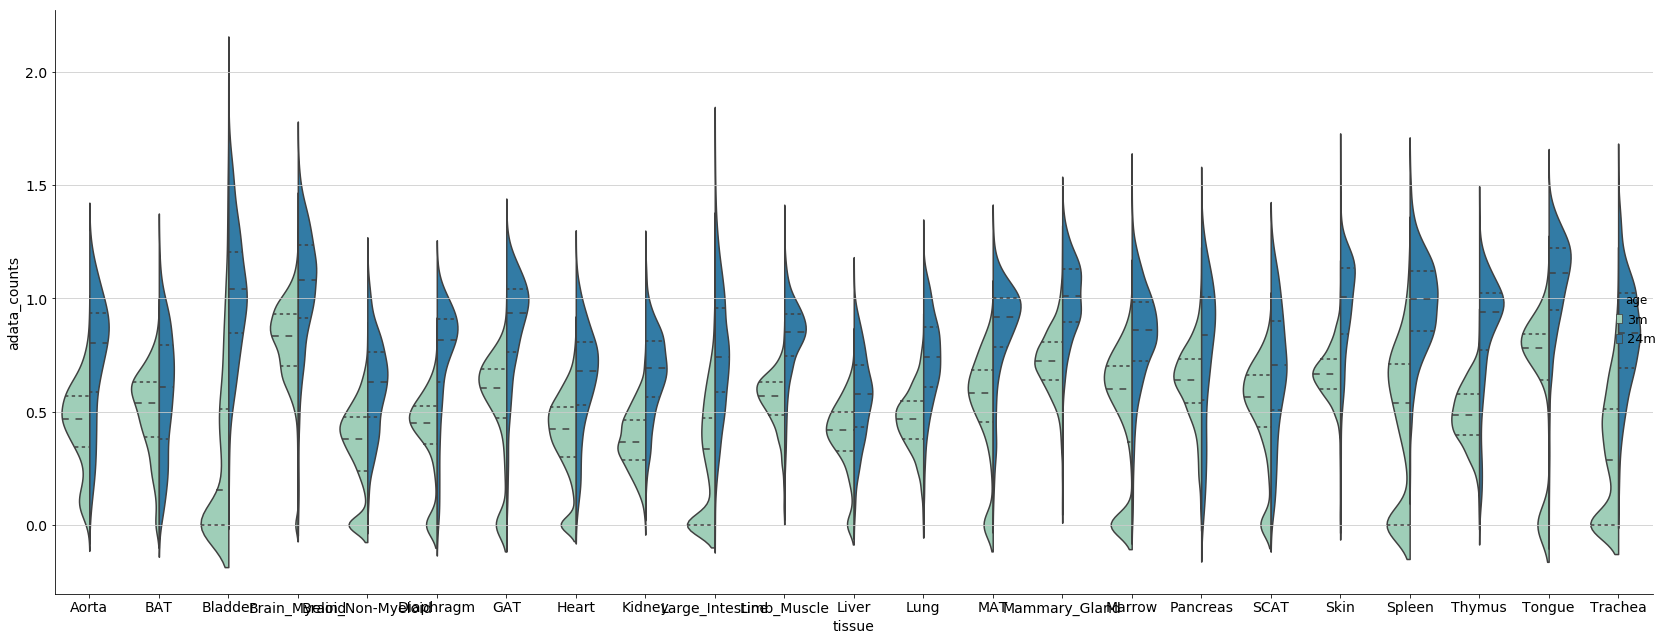

<Figure size 432x288 with 0 Axes>

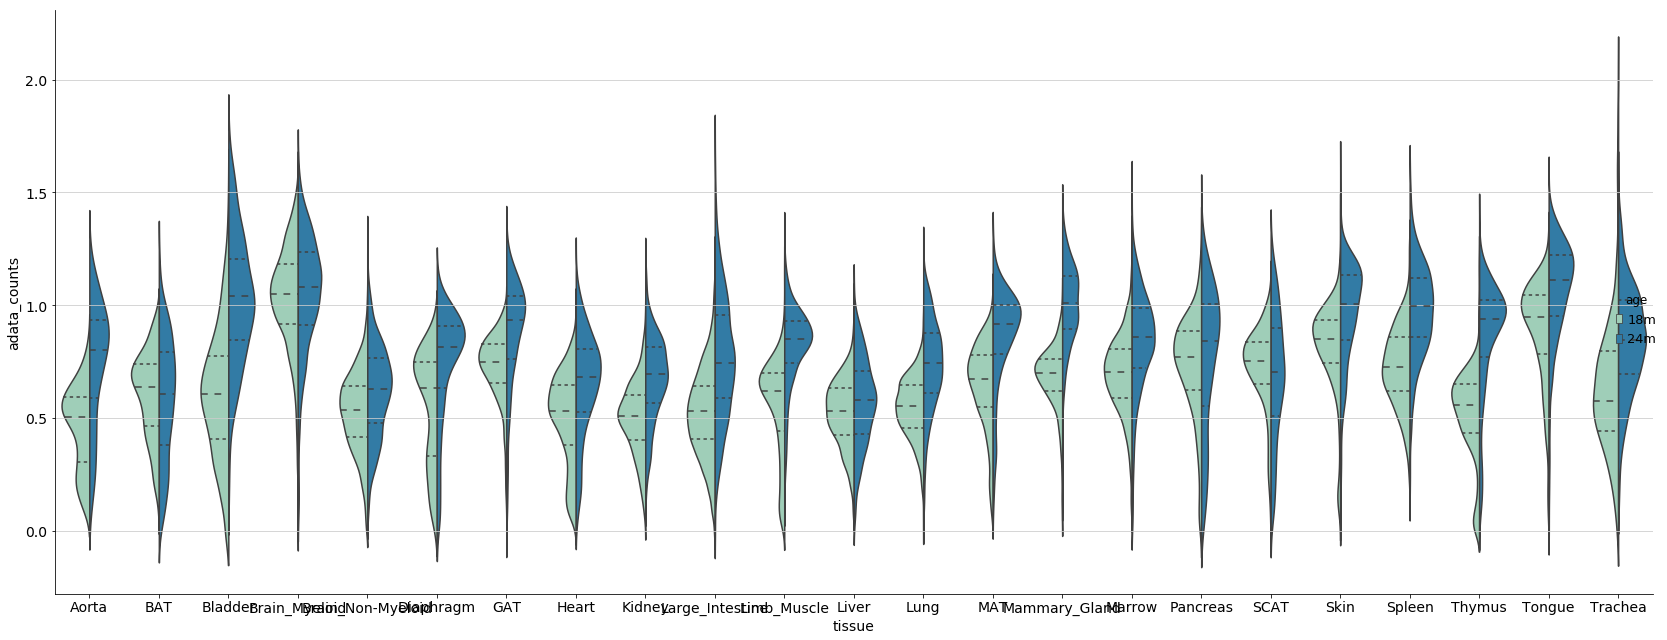

In [32]:
dataofinterest318 = df_mutations[df_mutations['age'].isin(['3m','18m'])]
dataofinterest318['tissue'] = dataofinterest318['tissue'].astype(str)
dataofinterest318['age'] = dataofinterest318['age'].astype(str)
plt.figure()
ax = sns.catplot(x="tissue", y="adata_counts", hue="age",
            kind="violin", split=True, palette="YlGnBu", inner="quartile",
                 order= tissue_list,
                 data=dataofinterest318, height=9, aspect=2.5);
plt.tight_layout()
# plt.savefig('../gatk-analysis/distribution_expression_3_18.pdf')

dataofinterest324 = df_mutations[df_mutations['age'].isin(['3m','21m','24m'])]
dataofinterest324 = dataofinterest324.replace('21m','24m')
dataofinterest324['tissue'] = dataofinterest324['tissue'].astype(str)
dataofinterest324['age'] = dataofinterest324['age'].astype(str)
plt.figure()
ax = sns.catplot(x="tissue", y="adata_counts", hue="age",
            kind="violin", split=True, palette="YlGnBu", inner="quartile",
                 order= tissue_list,
                 data=dataofinterest324, height=9, aspect=2.5);
plt.tight_layout()
# plt.savefig('../gatk-analysis/distribution_expression_3_24.pdf')

dataofinterest1824 = df_mutations[df_mutations['age'].isin(['18m','21m','24m'])]
dataofinterest1824 = dataofinterest1824.replace('21m','24m')
dataofinterest1824['tissue'] = dataofinterest1824['tissue'].astype(str)
dataofinterest1824['age'] = dataofinterest1824['age'].astype(str)
plt.figure()
ax = sns.catplot(x="tissue", y="adata_counts", hue="age",
            kind="violin", split=True, palette="YlGnBu", inner="quartile",
                 order= tissue_list,
                 data=dataofinterest1824, height=9, aspect=2.5);
plt.tight_layout()
# plt.savefig('../gatk-analysis/distribution_expression_18_24.pdf')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

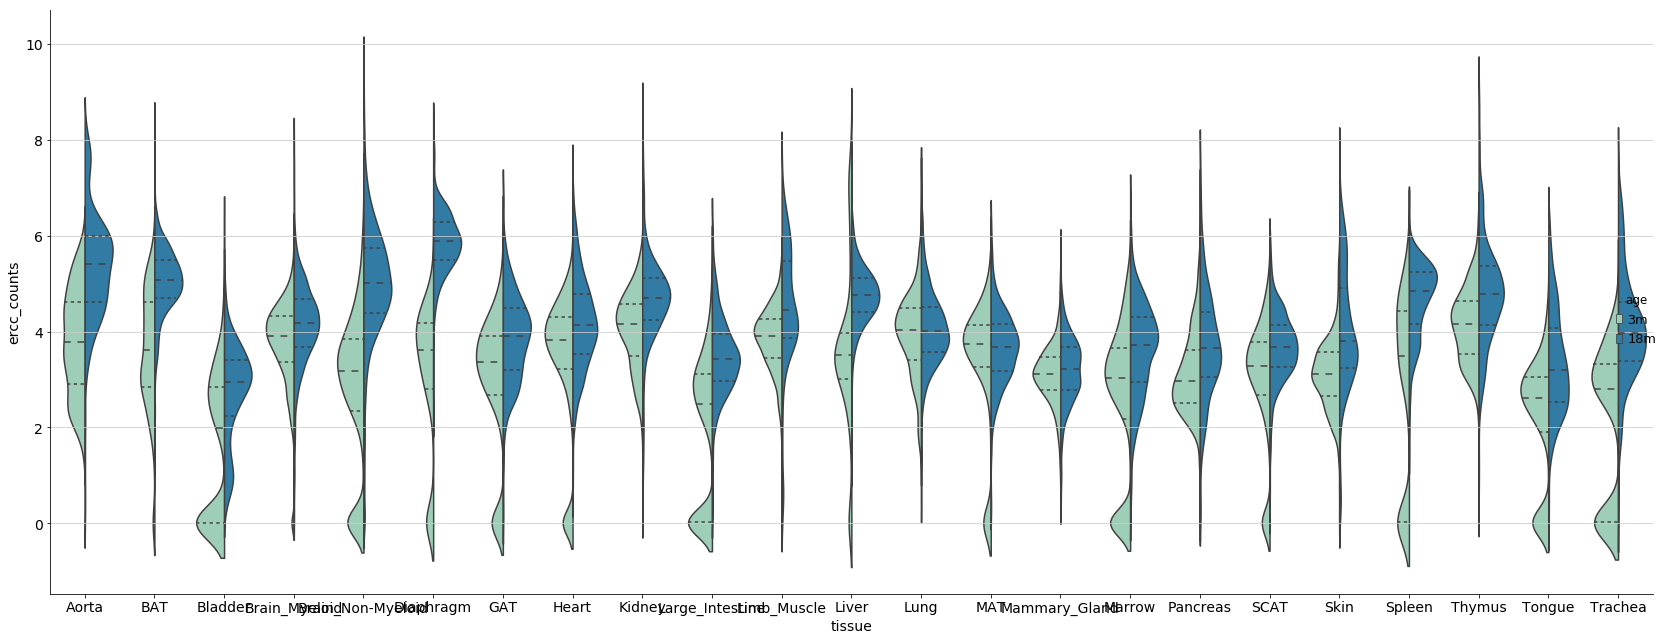

<Figure size 432x288 with 0 Axes>

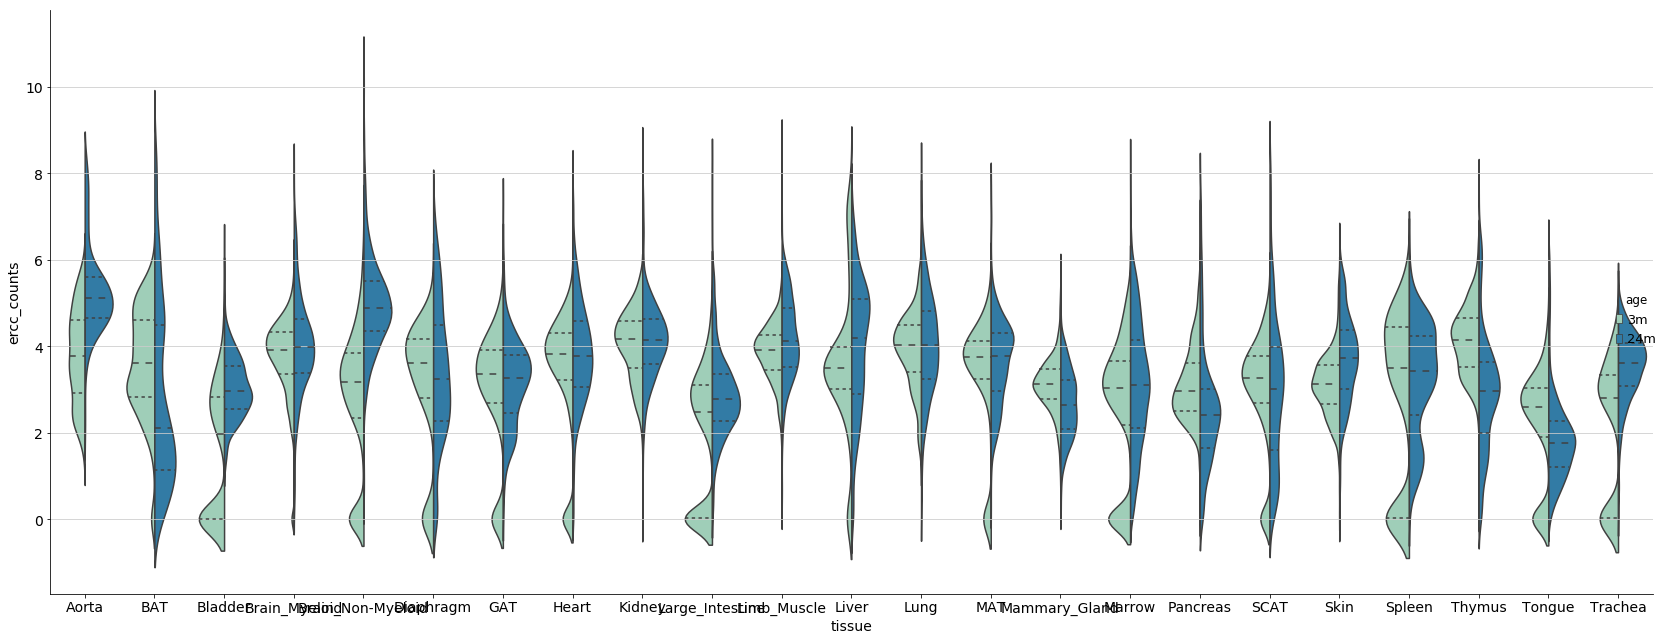

<Figure size 432x288 with 0 Axes>

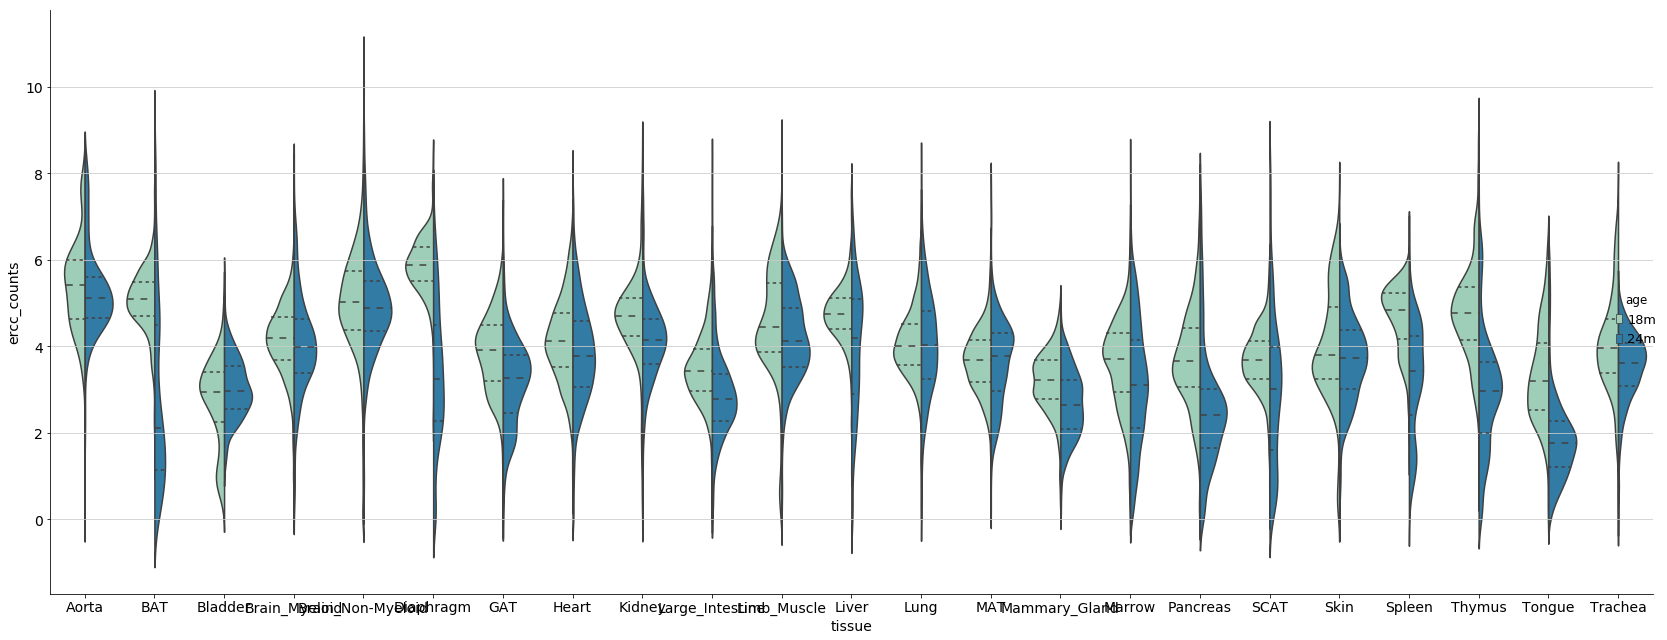

In [33]:
dataofinterest318 = df_mutations[df_mutations['age'].isin(['3m','18m'])]
dataofinterest318['tissue'] = dataofinterest318['tissue'].astype(str)
dataofinterest318['age'] = dataofinterest318['age'].astype(str)
plt.figure()
ax = sns.catplot(x="tissue", y="ercc_counts", hue="age",
            kind="violin", split=True, palette="YlGnBu", inner="quartile",
                 order= tissue_list,
                 data=dataofinterest318, height=9, aspect=2.5);
plt.tight_layout()
# plt.savefig('../gatk-analysis/distribution_expression_ercc_3_18.pdf')

dataofinterest324 = df_mutations[df_mutations['age'].isin(['3m','21m','24m'])]
dataofinterest324 = dataofinterest324.replace('21m','24m')
dataofinterest324['tissue'] = dataofinterest324['tissue'].astype(str)
dataofinterest324['age'] = dataofinterest324['age'].astype(str)
plt.figure()
ax = sns.catplot(x="tissue", y="ercc_counts", hue="age",
            kind="violin", split=True, palette="YlGnBu", inner="quartile",
                 order= tissue_list,
                 data=dataofinterest324, height=9, aspect=2.5);
plt.tight_layout()
# plt.savefig('../gatk-analysis/distribution_expression_ercc_3_24.pdf')

dataofinterest1824 = df_mutations[df_mutations['age'].isin(['18m','21m','24m'])]
dataofinterest1824 = dataofinterest1824.replace('21m','24m')
dataofinterest1824['tissue'] = dataofinterest1824['tissue'].astype(str)
dataofinterest1824['age'] = dataofinterest1824['age'].astype(str)
plt.figure()
ax = sns.catplot(x="tissue", y="ercc_counts", hue="age",
            kind="violin", split=True, palette="YlGnBu", inner="quartile",
                 order= tissue_list,
                 data=dataofinterest1824, height=9, aspect=2.5);
plt.tight_layout()
# plt.savefig('../gatk-analysis/distribution_expression_ercc_18_24.pdf')

### Comparison kde

In [26]:
cell_type_functional_annots = pd.read_csv('../gatk-analysis/cell_ontology_class_functional_annotations.csv')
cell_type_functional_annots['functional_annotations'] = cell_type_functional_annots['functional_annotations'].replace('epithelial','parenchyma')
cell_type_functional_annots['functional_annotations'] = cell_type_functional_annots['functional_annotations'].replace('stem cell/progenitor','stem')

cell_type_functional_annots.head()

,tissue,cell_ontology_class,functional_annotations,Unnamed: 3
0,Aorta,aortic endothelial cell,endothelial,NaN
1,Aorta,epithelial cell,parenchyma,epithelial
2,Aorta,fibroblast of cardiac tissue,stromal,NaN
3,Aorta,fibrocyte,stromal,NaN
4,Aorta,macrophage,immune,NaN


In [27]:
set(cell_type_functional_annots['functional_annotations']),set(cell_type_functional_annots['Unnamed: 3'])

({'endothelial', 'immune', 'parenchyma', 'stem', 'stromal'},
 {'epithelial', 'muscle cell', nan, 'stem cell/progenitor'})

In [81]:
gatk_summary_csv = df_mutations2.copy()
gatk_summary_csv.to_csv('../gatk-analysis/gatk_summary.csv')

In [80]:
gatk_summary_csv.columns

Index(['ercc', 'adata', 'tissue', 'age', 'cell_ontology_class', 'ercc_counts',
       'adata_counts', 'ercc_raw_counts', 'adata_raw_counts', 'agenum',
       'functional_annotations'],
      dtype='object')

In [28]:
df_mutations2 = df_mutations.copy()
for t in list(set(df_mutations2['tissue'])):
    tiss_df_muts = df_mutations2[df_mutations2['tissue']==t].copy()
    for c in list(set(tiss_df_muts['cell_ontology_class'])):
        tiss_df_muts_cells = tiss_df_muts[tiss_df_muts['cell_ontology_class']==c]
        df_mutations2.loc[tiss_df_muts_cells.index,'functional_annotations'] = cell_type_functional_annots[(cell_type_functional_annots['tissue']==t) & (cell_type_functional_annots['cell_ontology_class']==c)]['functional_annotations'].values

df_mutations2


,ercc,adata,tissue,age,cell_ontology_class,ercc_counts,adata_counts,ercc_raw_counts,adata_raw_counts,agenum,functional_annotations
A1.B000126.3_39_F.1.1-1-1-0-0-0,0.060976,0.818919,Skin,3m,basal cell of epidermis,3.626939,0.598242,36.597557,0.818919,3.0,parenchyma
A1.B000127.3_38_F.1.1-1-1-0-0-0,0.060976,0.179487,SCAT,3m,endothelial cell,4.532206,0.165080,91.963417,0.179487,3.0,endothelial
A1.B000167.3_56_F.1.1-1-1-0-0-0,0.109756,1.200565,Mammary_Gland,3m,basal cell,2.905834,0.788714,17.280487,1.200565,3.0,parenchyma
A1.B000412.3_56_F.1.1-1-1-0-0-0,0.097561,0.314050,Heart,3m,endothelial cell of coronary artery,4.982353,0.273114,144.817062,0.314050,3.0,endothelial
A1.B000633.3_56_F.1.1-1-1-0-0-0,0.121951,1.074380,Heart,3m,monocyte,4.114266,0.729662,60.207310,1.074380,3.0,immune
...,...,...,...,...,...,...,...,...,...,...,...
P9_B002989_S369_L004.mus-8-0-1-1,0.231707,1.520000,Marrow,24m,hematopoietic stem cell,3.495398,0.924259,31.963413,1.520000,24.0,immune
P9_B002992_S369_L003.mus-8-0-1-1,0.060976,1.200000,Marrow,24m,naive B cell,5.237544,0.788457,187.207306,1.200000,24.0,immune
P9_B003231_S369_L004.mus-8-0-1-1,0.365854,1.355372,Heart,24m,T cell,4.503057,0.856699,89.292679,1.355372,24.0,immune
P9_B003233_S369_L003.mus-8-0-1-1,0.268293,0.950413,Heart,24m,endothelial cell of coronary artery,5.170830,0.668041,175.060974,0.950413,24.0,endothelial


In [29]:
df2 = df_mutations2.copy()
df2 = df2.replace('21m','24m')
df2 = df2.groupby(['tissue','age']).describe()
df2['tissue'] = [i[0] for i in df2.index]
df2['age'] = [i[1] for i in df2.index]
# df2['functional_annots'] = [i[1] for i in df2.index]
df2

ercc                                                    \
              count      mean       std       min       25%       50%   
tissue  age                                                             
Aorta   18m   316.0  0.136230  0.058686  0.024390  0.085366  0.134146   
        24m   224.0  0.140679  0.062246  0.012195  0.097561  0.134146   
        3m    366.0  0.087732  0.056466  0.000000  0.048780  0.073171   
BAT     18m   662.0  0.148755  0.062416  0.012195  0.109756  0.146341   
        24m   848.0  0.077715  0.067225  0.000000  0.024390  0.060976   
...             ...       ...       ...       ...       ...       ...   
Tongue  24m  1358.0  0.083570  0.049817  0.000000  0.048780  0.073171   
        3m   1382.0  0.067894  0.056464  0.000000  0.012195  0.060976   
Trachea 18m   807.0  0.096669  0.052417  0.000000  0.060976  0.097561   
        24m   999.0  0.139371  0.064358  0.000000  0.097561  0.134146   
        3m   1297.0  0.072108  0.066165  0.000000  0.000000  0.073171   

                                  adata            ...  agenum             \
                  75%       max   count      mean  ...   count  mean  std   
tissue  age                                        ...                      
Aorta   18m  0.170732  0.365854   316.0  0.610582  ...   316.0  18.0  0.0   
        24m  0.182927  0.329268   224.0  1.172522  ...   224.0  24.0  0.0   
        3m   0.121951  0.317073   366.0  0.573668  ...   366.0   3.0  0.0   
BAT     18m  0.182927  0.353658   662.0  0.858861  ...   662.0  18.0  0.0   
        24m  0.121951  0.341463   848.0  0.856691  ...   848.0  24.0  0.0   
...               ...       ...     ...       ...  ...     ...   ...  ...   
Tongue  24m  0.109756  0.317073  1358.0  1.977425  ...  1358.0  24.0  0.0   
        3m   0.109756  0.329268  1382.0  0.969080  ...  1382.0   3.0  0.0   
Trachea 18m  0.134146  0.280488   807.0  0.987195  ...   807.0  18.0  0.0   
        24m  0.182927  0.451219   999.0  1.383940  ...   999.0  24.0  0.0   
        3m   0.121951  0.317073  1297.0  0.406494  ...  1297.0   3.0  0.0   

                                            tissue  age  
              min   25%   50%   75%   max                
tissue  age                                              
Aorta   18m  18.0  18.0  18.0  18.0  18.0    Aorta  18m  
        24m  24.0  24.0  24.0  24.0  24.0    Aorta  24m  
        3m    3.0   3.0   3.0   3.0   3.0    Aorta   3m  
BAT     18m  18.0  18.0  18.0  18.0  18.0      BAT  18m  
        24m  24.0  24.0  24.0  24.0  24.0      BAT  24m  
...           ...   ...   ...   ...   ...      ...  ...  
Tongue  24m  24.0  24.0  24.0  24.0  24.0   Tongue  24m  
        3m    3.0   3.0   3.0   3.0   3.0   Tongue   3m  
Trachea 18m  18.0  18.0  18.0  18.0  18.0  Trachea  18m  
        24m  24.0  24.0  24.0  24.0  24.0  Trachea  24m  
        3m    3.0   3.0   3.0   3.0   3.0  Trachea   3m  

[69 rows x 58 columns]

In [30]:
df224 = df2[df2['age']=='24m'].copy()
df218 = df2[df2['age']=='18m'].copy()
df23 = df2[df2['age']=='3m'].copy()

In [31]:
df23.set_index('tissue')

ercc                                               \
                    count      mean       std  min       25%       50%   
tissue                                                                   
Aorta               366.0  0.087732  0.056466  0.0  0.048780  0.073171   
BAT                 709.0  0.103908  0.056381  0.0  0.060976  0.097561   
Bladder            1226.0  0.052710  0.060783  0.0  0.000000  0.036585   
Brain_Myeloid      4524.0  0.086622  0.052008  0.0  0.048780  0.085366   
Brain_Non-Myeloid  3376.0  0.070765  0.055426  0.0  0.024390  0.073171   
Diaphragm           897.0  0.070248  0.052727  0.0  0.036585  0.060976   
GAT                1427.0  0.084486  0.062153  0.0  0.036585  0.073171   
Heart              4344.0  0.085175  0.064691  0.0  0.036585  0.073171   
Kidney              502.0  0.085220  0.047716  0.0  0.048780  0.073171   
Large_Intestine    3786.0  0.058615  0.058130  0.0  0.000000  0.048780   
Limb_Muscle        1102.0  0.110509  0.053227  0.0  0.073171  0.109756   
Liver               728.0  0.149658  0.145401  0.0  0.048780  0.097561   
Lung               1381.0  0.097658  0.050154  0.0  0.060976  0.097561   
MAT                1150.0  0.081400  0.054903  0.0  0.036585  0.085366   
Mammary_Gland      1912.0  0.096840  0.052010  0.0  0.060976  0.085366   
Marrow             4911.0  0.064144  0.054920  0.0  0.012195  0.060976   
Pancreas           1588.0  0.086449  0.051593  0.0  0.048780  0.085366   
SCAT               1702.0  0.078086  0.055572  0.0  0.036585  0.073171   
Skin               2346.0  0.081899  0.047135  0.0  0.048780  0.073171   
Spleen             1623.0  0.072359  0.071721  0.0  0.000000  0.060976   
Thymus             1359.0  0.094034  0.053202  0.0  0.048780  0.085366   
Tongue             1382.0  0.067894  0.056464  0.0  0.012195  0.060976   
Trachea            1297.0  0.072108  0.066165  0.0  0.000000  0.073171   

                                        adata            ... adata_raw_counts  \
                        75%       max   count      mean  ...              max   
tissue                                                   ...                    
Aorta              0.121951  0.317073   366.0  0.573668  ...         1.457944   
BAT                0.146341  0.304878   709.0  0.670106  ...         1.460526   
Bladder            0.097561  0.268293  1226.0  0.494698  ...         6.166667   
Brain_Myeloid      0.121951  0.341463  4524.0  1.271267  ...         3.038216   
Brain_Non-Myeloid  0.109756  0.439024  3376.0  0.433172  ...         1.268293   
Diaphragm          0.097561  0.268293   897.0  0.513367  ...         1.260000   
GAT                0.121951  0.378049  1427.0  0.729537  ...         1.568889   
Heart              0.121951  0.548781  4344.0  0.501840  ...         1.338843   
Kidney             0.109756  0.243902   502.0  0.465471  ...         1.063492   
Large_Intestine    0.097561  0.378049  3786.0  0.382435  ...         2.600000   
Limb_Muscle        0.146341  0.292683  1102.0  0.745078  ...         1.317241   
Liver              0.195122  0.670732   728.0  0.496547  ...         1.189189   
Lung               0.121951  0.292683  1381.0  0.599219  ...         1.391304   
MAT                0.121951  0.292683  1150.0  0.737008  ...         1.621762   
Mammary_Gland      0.121951  0.353658  1912.0  1.075501  ...         2.532486   
Marrow             0.097561  0.402439  4911.0  0.708463  ...         1.900000   
Pancreas           0.121951  0.390244  1588.0  0.896129  ...         2.157894   
SCAT               0.109756  0.329268  1702.0  0.700047  ...         1.519231   
Skin               0.109756  0.341463  2346.0  0.959168  ...         2.064865   
Spleen             0.121951  0.402439  1623.0  0.655048  ...         2.357143   
Thymus             0.121951  0.329268  1359.0  0.633465  ...         1.446808   
Tongue             0.109756  0.329268  1382.0  0.969080  ...         2.046382   
Trachea            0.121951  0.317073  1297.0  0.406494  ...         2.

In [48]:
pwd

'/home/ubuntu/maca-scanpy/maca-data-analysis/analysis-scripts'

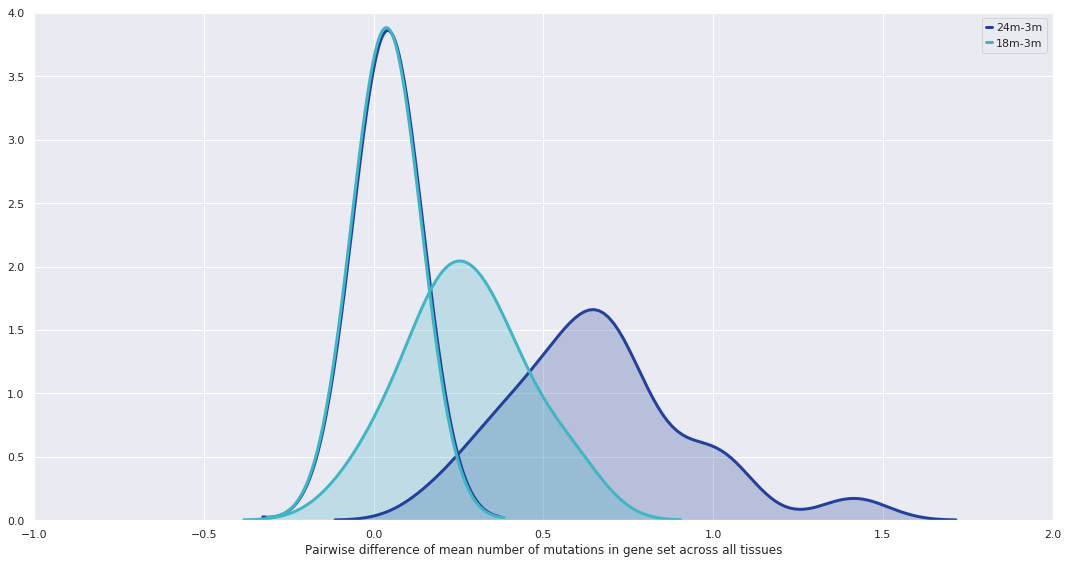

In [77]:
sns.set(rc={'figure.figsize':(15,8)})
g = sns.distplot(df224[('ercc','mean')].values-df23[('ercc','mean')].values,
             color='white',hist=False,
             kde_kws={"color": age_color_dict['24m'], "lw": 3, "label": "24m-3m", 'bw':.1})

g = sns.distplot(df224[('adata','mean')].values-df23[('adata','mean')].values,
             color=age_color_dict['24m'],hist=False,
             kde_kws={"color": age_color_dict['24m'], "lw": 3,"shade": True, 'bw':.1})

# g = sns.distplot(df224[('ercc','mean')].values-df218[('ercc','mean')].values,
#              color='white',
#              kde_kws={"color": age_color_dict['21m'], "lw": 3, "label": "24m-18m"})
# g = sns.distplot(df224[('adata','mean')].values-df218[('adata','mean')].values,
#              color=age_color_dict['21m'],
#              kde_kws={"color": age_color_dict['21m'], "lw": 3})

g = sns.distplot(df218[('ercc','mean')].values-df23[('ercc','mean')].values,
             color='white',hist=False,
             kde_kws={"color": age_color_dict['18m'], "lw": 3, "label": "18m-3m", 'bw':.1})
g = sns.distplot(df218[('adata','mean')].values-df23[('adata','mean')].values,
             color=age_color_dict['18m'],hist=False,
             kde_kws={"color": age_color_dict['18m'], "lw": 3,"shade": True, 'bw':.1})

g.set(xlabel='Pairwise difference of mean number of mutations in gene set across all tissues')
g.set(ylim=(0, 4),xlim=(-1., 2.))
plt.tight_layout()
plt.savefig('../gatk-analysis/fig3_diff_kde.pdf')

In [44]:
df3 = df_mutations2.copy()
df3 = df3.replace('21m','24m')
df3 = df3.groupby(['tissue','age','functional_annotations']).describe()
df3['tissue'] = [i[0] for i in df3.index]
df3['age'] = [i[1] for i in df3.index]
df3['functional_annotations'] = [i[2] for i in df3.index]
df3

ercc                                \
                                    count      mean       std       min   
tissue  age functional_annotations                                        
Aorta   18m endothelial             118.0  0.134766  0.056571  0.024390   
            immune                   58.0  0.139193  0.059175  0.048780   
            stromal                 140.0  0.136237  0.060579  0.024390   
        24m endothelial             160.0  0.140320  0.063758  0.012195   
            immune                   23.0  0.146341  0.058716  0.048780   
...                                   ...       ...       ...       ...   
Trachea 24m stromal                 411.0  0.135333  0.064503  0.012195   
        3m  endothelial             108.0  0.038279  0.061632  0.000000   
            immune                  199.0  0.074274  0.070314  0.000000   
            parenchyma              205.0  0.065497  0.066345  0.000000   
            stromal                 785.0  0.077940  0.064187  0.000000   

                                                                            \
                                         25%       50%       75%       max   
tissue  age functional_annotations                                           
Aorta   18m endothelial             0.097561  0.134146  0.170732  0.292683   
            immune                  0.085366  0.134146  0.170732  0.365854   
            stromal                 0.085366  0.134146  0.170732  0.292683   
        24m endothelial             0.097561  0.134146  0.182927  0.329268   
            immune                  0.109756  0.146341  0.182927  0.280488   
...                                      ...       ...       ...       ...   
Trachea 24m stromal                 0.085366  0.134146  0.170732  0.451219   
        3m  endothelial             0.000000  0.000000  0.085366  0.219512   
            immune                  0.000000  0.073171  0.121951  0.304878   
            parenchyma              0.000000  0.048780  0.121951  0.268293   
            stromal                 0.000000  0.073171  0.121951  0.317073   

                                    adata            ... agenum             \
                                    count      mean  ...   mean  std   min   
tissue  age functional_annotations                   ...                     
Aorta   18m endothelial             118.0  0.645097  ...   18.0  0.0  18.0   
            immune                   58.0  0.269417  ...   18.0  0.0  18.0   
            stromal                 140.0  0.722830  ...   18.0  0.0  18.0   
        24m endothelial             160.0  1.270970  ...   24.0  0.0  24.0   
            immune                   23.0  0.937017  ...   24.0  0.0  24.0   
...                                   ...       ...  ...    ...  ...   ...   
Trachea 24m stromal                 411.0  1.424980  ...   24.0  0.0  24.0   
        3m  endothelial             108.0  0.239712  ...    3.0  0.0   3.0   
            immune                  199.0  0.463428  ...    3.0  0.0   3.0   
            parenchyma              205.0  0.356098  ...    3.0  0.0   3.0   
            stromal                 785.0  0.428167  ...    3.0  0.0   3.0   

                                                             tissue  age  \
                                     25%   50%   75%   max                 
tissue  age functional_annotations                                         
Aorta   18m endothelial             18.0  18.0  18.0  18.0    Aorta  18m   
            immune                  18.0  18.0  18.0  18.0    Aorta  18m   
            stromal                 18.0  18.0  18.0  18.0    Aorta  18m   
        24m endothelial             24.0  24.0  24.0  24.0    Aorta  24m   
            immune                  24.0  24.0  24.0  24.0    Aorta  24m   
...                                  ...   ...   ...   ...      ...  ...   
Trachea 24m stromal                 24.0  24.0  24.0  24.0  Trachea  24m   
        3m  endothelial              3.0

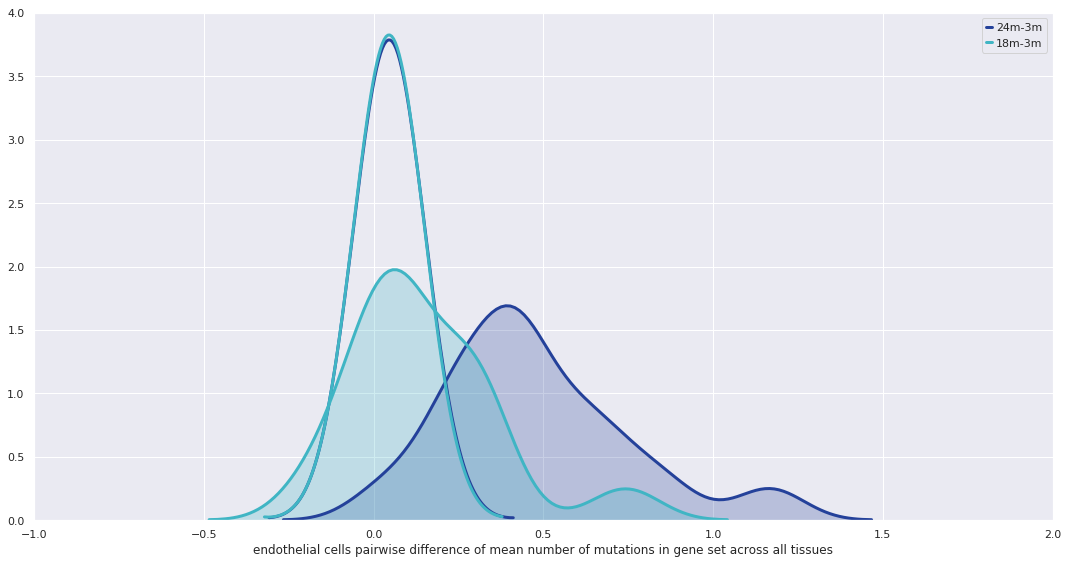

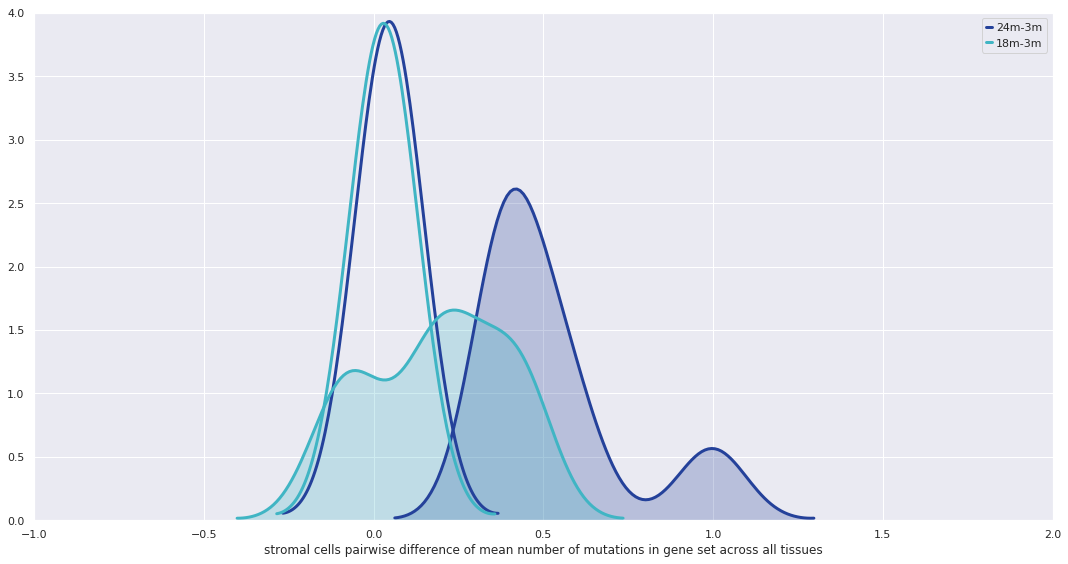

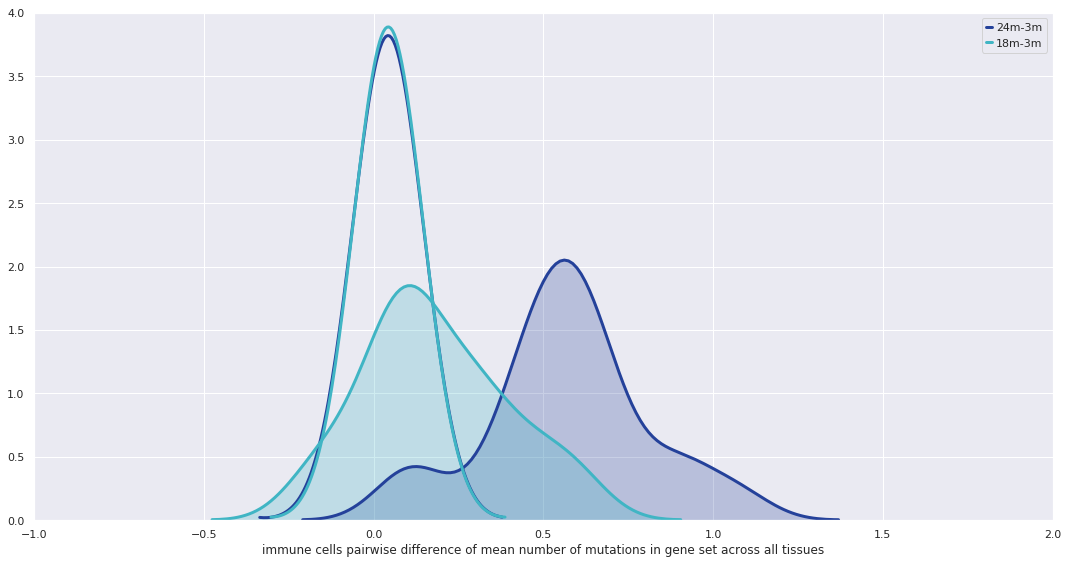

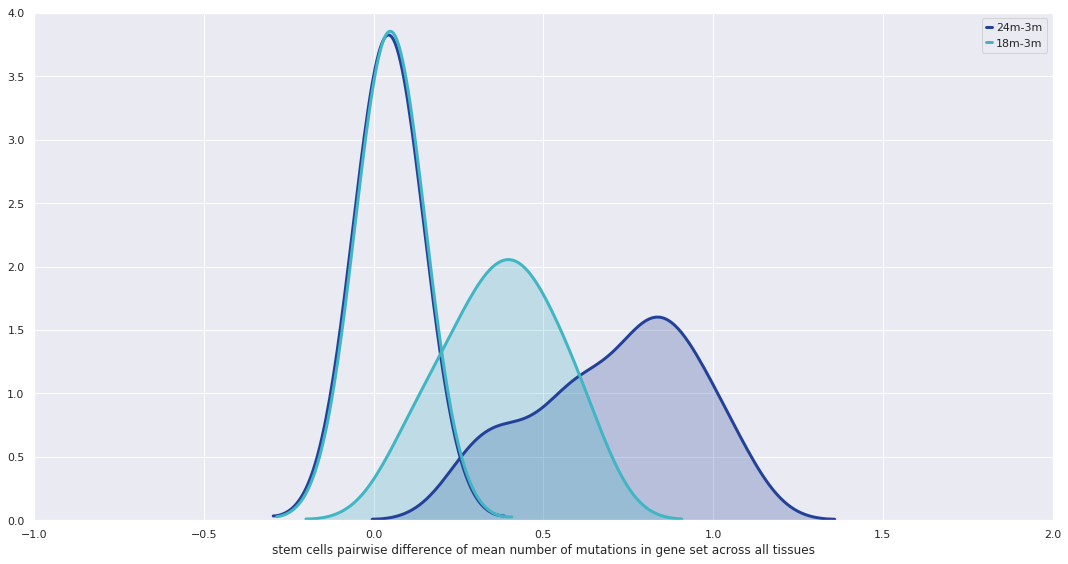

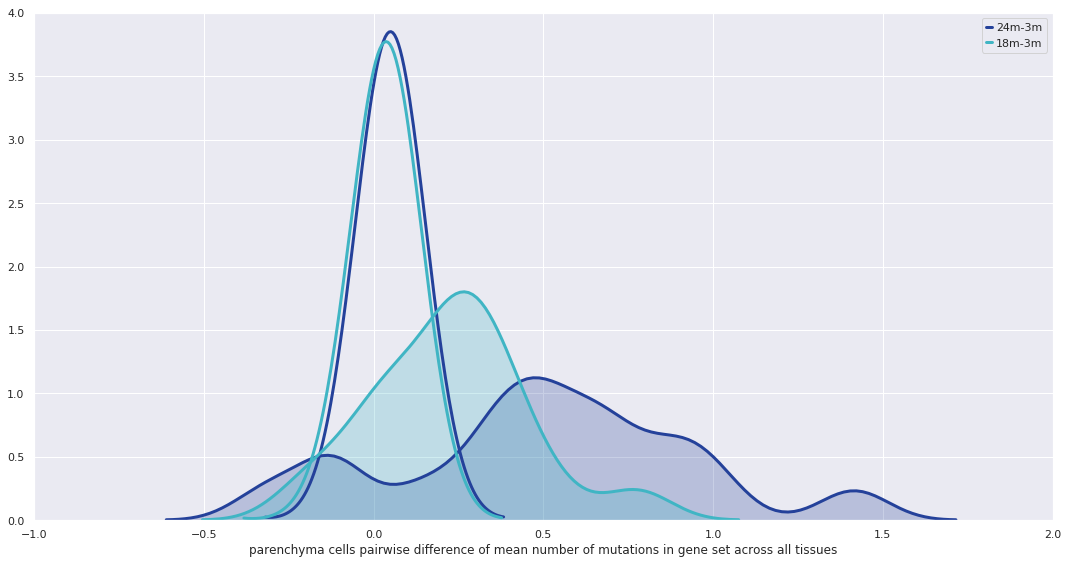

In [76]:
for fa in list(set(df3['functional_annotations'])):
    df3aux = df3[df3['functional_annotations']==fa].copy()
    
    for t in list(set(df3aux['tissue'])):
        if len(df3aux[df3aux['tissue']==t])<3:
            df3aux = df3aux.drop(df3aux[df3aux['tissue']==t].index)
            
    df3aux24 = df3aux[df3aux['age']=='24m'].copy()
    df3aux18 = df3aux[df3aux['age']=='18m'].copy()
    df3aux3 = df3aux[df3aux['age']=='3m'].copy()
    
    plt.figure()
    sns.set(rc={'figure.figsize':(15,8)})
    g = sns.distplot(df3aux24[('ercc','mean')].values-df3aux3[('ercc','mean')].values,
                 color='white',hist=False,
                 kde_kws={"color": age_color_dict['24m'], "lw": 3, "label": "24m-3m", 'bw':.1})

    g = sns.distplot(df3aux24[('adata','mean')].values-df3aux3[('adata','mean')].values,
                 color=age_color_dict['24m'],hist=False,
                 kde_kws={"color": age_color_dict['24m'], "lw": 3,"shade": True, 'bw':.1})

#     g = sns.distplot(df3aux24[('ercc','mean')].values-df3aux18[('ercc','mean')].values,
#                  color='white',
#                  kde_kws={"color": age_color_dict['21m'], "lw": 3, "label": "24m-18m"})
#     g = sns.distplot(df3aux24[('adata','mean')].values-df3aux18[('adata','mean')].values,
#                  color=age_color_dict['21m'],
#                  kde_kws={"color": age_color_dict['21m'], "lw": 3})

    g = sns.distplot(df3aux18[('ercc','mean')].values-df3aux3[('ercc','mean')].values,
                 color='white',hist=False,
                 kde_kws={"color": age_color_dict['18m'], "lw": 3, "label": "18m-3m", 'bw':.1})
    g = sns.distplot(df3aux18[('adata','mean')].values-df3aux3[('adata','mean')].values,
                 color=age_color_dict['18m'],hist=False,
                 kde_kws={"color": age_color_dict['18m'], "lw": 3,"shade": True, 'bw':.1})

    g.set(xlabel=fa+' cells pairwise difference of mean number of mutations in gene set across all tissues')
    g.set(ylim=(0, 4),xlim=(-1., 2.))
    plt.tight_layout()
    plt.savefig('../gatk-analysis/fig3_diff_kde_'+fa+'.pdf')